# 해당 코드는 오른쪽 팔꿈치를 계산하는 것을 기준으로 작성되었습니다.  
이외 다른 joint를 위해서는 custom이 필요합니다.  
"저장한 pointcloud와 color array를 matching 합니다" 까지는 좌우 어깨,팔꿈치,손목의 좌표를 다룹니다.  
이후 각도를 계산하는 과정부터 오른쪽 어깨, 팔꿈치, 손목만을 인덱싱하여 사용합니다.  
필요한 부분을 custom하여 사용하시면 됩니다.

# pyrealsense를 활용해 point cloud와 color array를 저장합니다
## <사전 param 설정>
아래 코드는 realsense에서 데이터를 받아오기 전 필요한 사전 설정들 입니다. 개발중 코드를 수정하는 과정에서 빠진 부분들이 있어 필요없는 사전 설정도 꽤 많이 들어있지만 혹시 몰라서 그냥 두었습니다.

In [1]:
# License: Apache 2.0. See LICENSE file in root directory.
# Copyright(c) 2015-2017 Intel Corporation. All Rights Reserved.

"""
OpenCV and Numpy Point cloud Software Renderer
This sample is mostly for demonstration and educational purposes.
It really doesn't offer the quality or performance that can be
achieved with hardware acceleration.
Usage:
------
Mouse: 
    Drag with left button to rotate around pivot (thick small axes), 
    with right button to translate and the wheel to zoom.
Keyboard: 
    [p]     Pause
    [r]     Reset View
    [d]     Cycle through decimation values
    [z]     Toggle point scaling
    [c]     Toggle color source
    [s]     Save PNG (./out.png)
    [e]     Export points to ply (./out.ply)
    [q\ESC] Quit
"""

import math
import time
import cv2
import numpy as np
import pyrealsense2 as rs
import os


class AppState:

    def __init__(self, *args, **kwargs):
        self.WIN_NAME = 'RealSense'
        self.pitch, self.yaw = math.radians(-10), math.radians(-15)
        self.translation = np.array([0, 0, -1], dtype=np.float32)
        self.distance = 2
        self.prev_mouse = 0, 0
        self.mouse_btns = [False, False, False]
        self.paused = False
        self.decimate = 1
        self.scale = True
        self.color = True

    def reset(self):
        self.pitch, self.yaw, self.distance = 0, 0, 2
        self.translation[:] = 0, 0, -1

    @property
    def rotation(self):
        Rx, _ = cv2.Rodrigues((self.pitch, 0, 0))
        Ry, _ = cv2.Rodrigues((0, self.yaw, 0))
        return np.dot(Ry, Rx).astype(np.float32)

    @property
    def pivot(self):
        return self.translation + np.array((0, 0, self.distance), dtype=np.float32)


state = AppState()

# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
pipeline.start(config)

# Get stream profile and camera intrinsics
profile = pipeline.get_active_profile()
depth_profile = rs.video_stream_profile(profile.get_stream(rs.stream.depth))
depth_intrinsics = depth_profile.get_intrinsics()
w, h = depth_intrinsics.width, depth_intrinsics.height

# Processing blocks
pc = rs.pointcloud()
decimate = rs.decimation_filter()
decimate.set_option(rs.option.filter_magnitude, 2 ** state.decimate)
colorizer = rs.colorizer()


def mouse_cb(event, x, y, flags, param):

    if event == cv2.EVENT_LBUTTONDOWN:
        state.mouse_btns[0] = True

    if event == cv2.EVENT_LBUTTONUP:
        state.mouse_btns[0] = False

    if event == cv2.EVENT_RBUTTONDOWN:
        state.mouse_btns[1] = True

    if event == cv2.EVENT_RBUTTONUP:
        state.mouse_btns[1] = False

    if event == cv2.EVENT_MBUTTONDOWN:
        state.mouse_btns[2] = True

    if event == cv2.EVENT_MBUTTONUP:
        state.mouse_btns[2] = False

    if event == cv2.EVENT_MOUSEMOVE:

        h, w = out.shape[:2]
        dx, dy = x - state.prev_mouse[0], y - state.prev_mouse[1]

        if state.mouse_btns[0]:
            state.yaw += float(dx) / w * 2
            state.pitch -= float(dy) / h * 2

        elif state.mouse_btns[1]:
            dp = np.array((dx / w, dy / h, 0), dtype=np.float32)
            state.translation -= np.dot(state.rotation, dp)

        elif state.mouse_btns[2]:
            dz = math.sqrt(dx**2 + dy**2) * math.copysign(0.01, -dy)
            state.translation[2] += dz
            state.distance -= dz

    if event == cv2.EVENT_MOUSEWHEEL:
        dz = math.copysign(0.1, flags)
        state.translation[2] += dz
        state.distance -= dz

    state.prev_mouse = (x, y)


cv2.namedWindow(state.WIN_NAME, cv2.WINDOW_AUTOSIZE)
cv2.resizeWindow(state.WIN_NAME, w, h)
cv2.setMouseCallback(state.WIN_NAME, mouse_cb)


def project(v):
    """project 3d vector array to 2d"""
    h, w = out.shape[:2]
    view_aspect = float(h)/w

    # ignore divide by zero for invalid depth
    with np.errstate(divide='ignore', invalid='ignore'):
        proj = v[:, :-1] / v[:, -1, np.newaxis] * \
            (w*view_aspect, h) + (w/2.0, h/2.0)

    # near clipping
    znear = 0.03
    proj[v[:, 2] < znear] = np.nan
    return proj


def view(v):
    """apply view transformation on vector array"""
    return np.dot(v - state.pivot, state.rotation) + state.pivot - state.translation


def line3d(out, pt1, pt2, color=(0x80, 0x80, 0x80), thickness=1):
    """draw a 3d line from pt1 to pt2"""
    p0 = project(pt1.reshape(-1, 3))[0]
    p1 = project(pt2.reshape(-1, 3))[0]
    if np.isnan(p0).any() or np.isnan(p1).any():
        return
    p0 = tuple(p0.astype(int))
    p1 = tuple(p1.astype(int))
    rect = (0, 0, out.shape[1], out.shape[0])
    inside, p0, p1 = cv2.clipLine(rect, p0, p1)
    if inside:
        cv2.line(out, p0, p1, color, thickness, cv2.LINE_AA)


def grid(out, pos, rotation=np.eye(3), size=1, n=10, color=(0x80, 0x80, 0x80)):
    """draw a grid on xz plane"""
    pos = np.array(pos)
    s = size / float(n)
    s2 = 0.5 * size
    for i in range(0, n+1):
        x = -s2 + i*s
        line3d(out, view(pos + np.dot((x, 0, -s2), rotation)),
               view(pos + np.dot((x, 0, s2), rotation)), color)
    for i in range(0, n+1):
        z = -s2 + i*s
        line3d(out, view(pos + np.dot((-s2, 0, z), rotation)),
               view(pos + np.dot((s2, 0, z), rotation)), color)


def axes(out, pos, rotation=np.eye(3), size=0.075, thickness=2):
    """draw 3d axes"""
    line3d(out, pos, pos +
           np.dot((0, 0, size), rotation), (0xff, 0, 0), thickness)
    line3d(out, pos, pos +
           np.dot((0, size, 0), rotation), (0, 0xff, 0), thickness)
    line3d(out, pos, pos +
           np.dot((size, 0, 0), rotation), (0, 0, 0xff), thickness)


def frustum(out, intrinsics, color=(0x40, 0x40, 0x40)):
    """draw camera's frustum"""
    orig = view([0, 0, 0])
    w, h = intrinsics.width, intrinsics.height

    for d in range(1, 6, 2):
        def get_point(x, y):
            p = rs.rs2_deproject_pixel_to_point(intrinsics, [x, y], d)
            line3d(out, orig, view(p), color)
            return p

        top_left = get_point(0, 0)
        top_right = get_point(w, 0)
        bottom_right = get_point(w, h)
        bottom_left = get_point(0, h)

        line3d(out, view(top_left), view(top_right), color)
        line3d(out, view(top_right), view(bottom_right), color)
        line3d(out, view(bottom_right), view(bottom_left), color)
        line3d(out, view(bottom_left), view(top_left), color)


def pointcloud(out, verts, texcoords, color, painter=True):
    """draw point cloud with optional painter's algorithm"""
    if painter:
        # Painter's algo, sort points from back to front

        # get reverse sorted indices by z (in view-space)
        # https://gist.github.com/stevenvo/e3dad127598842459b68
        v = view(verts)
        s = v[:, 2].argsort()[::-1]
        proj = project(v[s])
    else:
        proj = project(view(verts))

    if state.scale:
        proj *= 0.5**state.decimate

    h, w = out.shape[:2]

    # proj now contains 2d image coordinates
    j, i = proj.astype(np.uint32).T

    # create a mask to ignore out-of-bound indices
    im = (i >= 0) & (i < h)
    jm = (j >= 0) & (j < w)
    m = im & jm

    cw, ch = color.shape[:2][::-1]
    if painter:
        # sort texcoord with same indices as above
        # texcoords are [0..1] and relative to top-left pixel corner,
        # multiply by size and add 0.5 to center
        v, u = (texcoords[s] * (cw, ch) + 0.5).astype(np.uint32).T
    else:
        v, u = (texcoords * (cw, ch) + 0.5).astype(np.uint32).T
    # clip texcoords to image
    np.clip(u, 0, ch-1, out=u)
    np.clip(v, 0, cw-1, out=v)

    # perform uv-mapping
    out[i[m], j[m]] = color[u[m], v[m]]



out = np.empty((h, w, 3), dtype=np.uint8)

def get_verts(name):
    npsavePath='C://Users//user//Desktop//openPose//pointcloud/'+name
    pc_token = np.load(npsavePath)
    return pc_token

def zero_filter(x):
    if (x[2] > 1.5) and (x[2] < 3):
        return [x[0],x[1],x[2]]
    else:
        return [0,0,0]
    
def binary(x):
    if (x == 0):
        return 0
    else:
        return 0.5
   

In [2]:
framecount =0

# First import the library
import pyrealsense2 as rs
# Import Numpy for easy array manipulation
import numpy as np
# Import OpenCV for easy image rendering
import cv2

# Create a pipeline
pipeline = rs.pipeline()

#Create a config and configure the pipeline to stream
#  different resolutions of color and depth streams
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
profile = pipeline.start(config)

# Getting the depth sensor's depth scale (see rs-align example for explanation)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
print("Depth Scale is: " , depth_scale)

# We will be removing the background of objects more than
#  clipping_distance_in_meters meters away
clipping_distance_in_meters = 1 #1 meter
clipping_distance = clipping_distance_in_meters / depth_scale

# Create an align object
# rs.align allows us to perform alignment of depth frames to others frames
# The "align_to" is the stream type to which we plan to align depth frames.
align_to = rs.stream.color
align = rs.align(align_to)


Depth Scale is:  0.0010000000474974513


## <데이터 저장>
아래 셀을 실행하면 지정된 경로에 color array와 poiont cloud array를 npy 형식으로 저장합니다. esc를 누르면 종료됩니다.


In [3]:
i=0
sums=np.zeros((76800, 3))
u_sum=np.zeros((76800, 3))
framecount =0

while True:
    # Grab camera data
    if not state.paused:
        # Wait for a coherent pair of frames: depth and color
        frames = pipeline.wait_for_frames()

        depth_frame = frames.get_depth_frame()
        color_frame = frames.get_color_frame()

        depth_frame = decimate.process(depth_frame)

        # Grab new intrinsics (may be changed by decimation)
        depth_intrinsics = rs.video_stream_profile(
            depth_frame.profile).get_intrinsics()
        w, h = depth_intrinsics.width, depth_intrinsics.height

        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())

        depth_colormap = np.asanyarray(
            colorizer.colorize(depth_frame).get_data())

        if state.color:
            mapped_frame, color_source = color_frame, color_image
        else:
            mapped_frame, color_source = depth_frame, depth_colormap
        
        points = pc.calculate(depth_frame)
        pc.map_to(mapped_frame)
        
        # Pointcloud data to arrays
        v, t = points.get_vertices(), points.get_texture_coordinates()
        verts = np.asanyarray(v).view(np.float32).reshape(-1, 3)  # xyz
        npsavePath='C://Users//user//Desktop//openPose//outputs//pointcloud/'+str(framecount).zfill(5)
        np.save(npsavePath,verts)
        
        #textcoords는 plot을 위해 필요한 부분이나 신경쓰지 않아도 문제 없습니다!
        texcoords = np.asanyarray(t).view(np.float32).reshape(-1, 2)  # uv
        tcsavePath='C://Users//user//Desktop//openPose//outputs//texcoords/'+str(framecount)
        #np.save(tcsavePath,texcoords)
        
        plysavePath='C://Users//user//Desktop//openPose//outputs//ply/'+str(framecount)+'.ply'
        #points.export_to_ply(plysavePath, mapped_frame)
        
        ###############################################
        
        aligned_frames = align.process(frames)

        # Get aligned frames
        aligned_depth_frame = aligned_frames.get_depth_frame() # aligned_depth_frame is a 640x480 depth image
        color_frame = aligned_frames.get_color_frame()

        # Validate that both frames are valid
        if not aligned_depth_frame or not color_frame:
            print('Error, fail to get depth or color frame')
            continue

        depth_image = np.asanyarray(aligned_depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())
        
        #아래 경로는 depth 와 color의 array의 저장 경로입니다. 데이터의 sorting을 위해 저장하는 데이터 양에 따라 .zfill()을 조정하여 이용하시면 됩니다.
        savePath_d = 'C://Users//user//Desktop//openPose//outputs//test_depth_array/' + str(framecount).zfill(5)
        savePath_c = 'C://Users//user//Desktop//openPose//outputs//test_color_array/' + str(framecount).zfill(5)
        np.save(savePath_d,depth_image)
        np.save(savePath_c,color_image)#1개의 배열을 NumPy format의 바이너리 파일로 저장하기 (Save a single array to a binary file in NumPy format)
        
        # Render images
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
        images = np.hstack((color_image, depth_colormap))
        cv2.namedWindow('Align Example', cv2.WINDOW_AUTOSIZE)
        cv2.imshow('Align Example', images)
        
        key = cv2.waitKey(1)
        print('frame : ',framecount)
        print('time : 'framecount/30,'sec')
        framecount = framecount+1
        # Press esc or 'q' to close the image window
        if key & 0xFF == ord('q') or key == 27:
            cv2.destroyAllWindows()
            break

# Stop streaming

frame :  0
frame :  1
frame :  2
frame :  3
frame :  4
frame :  5
frame :  6
frame :  7
frame :  8
frame :  9
frame :  10
frame :  11
frame :  12
frame :  13
frame :  14
frame :  15
frame :  16
frame :  17
frame :  18
frame :  19
frame :  20
frame :  21
frame :  22
frame :  23
frame :  24
frame :  25
frame :  26
frame :  27
frame :  28
frame :  29
frame :  30
frame :  31
frame :  32
frame :  33
frame :  34
frame :  35
frame :  36
frame :  37
frame :  38
frame :  39
frame :  40
frame :  41
frame :  42
frame :  43
frame :  44
frame :  45
frame :  46
frame :  47
frame :  48
frame :  49
frame :  50
frame :  51
frame :  52
frame :  53
frame :  54
frame :  55
frame :  56
frame :  57
frame :  58
frame :  59
frame :  60
frame :  61
frame :  62
frame :  63
frame :  64
frame :  65
frame :  66
frame :  67
frame :  68
frame :  69
frame :  70
frame :  71
frame :  72
frame :  73
frame :  74
frame :  75
frame :  76
frame :  77
frame :  78
frame :  79
frame :  80
frame :  81
frame :  82
frame :  83
fr

frame :  644
frame :  645
frame :  646
frame :  647
frame :  648
frame :  649
frame :  650
frame :  651
frame :  652
frame :  653
frame :  654
frame :  655
frame :  656
frame :  657
frame :  658
frame :  659
frame :  660
frame :  661
frame :  662
frame :  663
frame :  664
frame :  665
frame :  666
frame :  667
frame :  668
frame :  669
frame :  670
frame :  671
frame :  672
frame :  673
frame :  674
frame :  675
frame :  676
frame :  677
frame :  678
frame :  679
frame :  680
frame :  681
frame :  682
frame :  683
frame :  684
frame :  685
frame :  686
frame :  687
frame :  688
frame :  689
frame :  690
frame :  691
frame :  692
frame :  693
frame :  694
frame :  695
frame :  696
frame :  697
frame :  698
frame :  699
frame :  700
frame :  701
frame :  702
frame :  703
frame :  704
frame :  705
frame :  706
frame :  707
frame :  708
frame :  709
frame :  710
frame :  711
frame :  712
frame :  713
frame :  714
frame :  715
frame :  716
frame :  717
frame :  718
frame :  719
frame :  720

# 저장한 array를 color image와 video로 변환합니다
realsense를 통해 녹화한color array를 opencv를 통해image와 video로 저장합니다

In [2]:
import os
import numpy as np
import cv2

videopath = 'C://Users//user//Desktop//openPose//outputs//test_color_array/'
frame_list = sorted(os.listdir(videopath)) 
print(frame_list)

outputVideo = []

for j in frame_list :#frame별 slice
    open_frame = videopath +'//' + j
    save_load = np.load(open_frame)
    #이미지 저장부분. 경로 설정, 각 이미지의 이름은 프레임으로 저장됨
    imagepath = 'C://Users//user//Desktop//openPose//outputs//frames/'
    imagename = j+'.jpg'
    cv2.imwrite(os.path.join(imagepath ,imagename), save_load)
    print(j,save_load.shape)
    outputVideo.append(save_load)

#비디오 저장 부분. 저장할 경로와 비디오 이름, 형식 설정
out = cv2.VideoWriter('C://Users/user/Desktop/openPose//outputs/raw_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, (640,480))

for i in range(len(outputVideo)):
    out.write(outputVideo[i])
              
out.release()

['00000.npy', '00001.npy', '00002.npy', '00003.npy', '00004.npy', '00005.npy', '00006.npy', '00007.npy', '00008.npy', '00009.npy', '00010.npy', '00011.npy', '00012.npy', '00013.npy', '00014.npy', '00015.npy', '00016.npy', '00017.npy', '00018.npy', '00019.npy', '00020.npy', '00021.npy', '00022.npy', '00023.npy', '00024.npy', '00025.npy', '00026.npy', '00027.npy', '00028.npy', '00029.npy', '00030.npy', '00031.npy', '00032.npy', '00033.npy', '00034.npy', '00035.npy', '00036.npy', '00037.npy', '00038.npy', '00039.npy', '00040.npy', '00041.npy', '00042.npy', '00043.npy', '00044.npy', '00045.npy', '00046.npy', '00047.npy', '00048.npy', '00049.npy', '00050.npy', '00051.npy', '00052.npy', '00053.npy', '00054.npy', '00055.npy', '00056.npy', '00057.npy', '00058.npy', '00059.npy', '00060.npy', '00061.npy', '00062.npy', '00063.npy', '00064.npy', '00065.npy', '00066.npy', '00067.npy', '00068.npy', '00069.npy', '00070.npy', '00071.npy', '00072.npy', '00073.npy', '00074.npy', '00075.npy', '00076.npy'

00014.npy (480, 640, 3)
00015.npy (480, 640, 3)
00016.npy (480, 640, 3)
00017.npy (480, 640, 3)
00018.npy (480, 640, 3)
00019.npy (480, 640, 3)
00020.npy (480, 640, 3)
00021.npy (480, 640, 3)
00022.npy (480, 640, 3)
00023.npy (480, 640, 3)
00024.npy (480, 640, 3)
00025.npy (480, 640, 3)
00026.npy (480, 640, 3)
00027.npy (480, 640, 3)
00028.npy (480, 640, 3)
00029.npy (480, 640, 3)
00030.npy (480, 640, 3)
00031.npy (480, 640, 3)
00032.npy (480, 640, 3)
00033.npy (480, 640, 3)
00034.npy (480, 640, 3)
00035.npy (480, 640, 3)
00036.npy (480, 640, 3)
00037.npy (480, 640, 3)
00038.npy (480, 640, 3)
00039.npy (480, 640, 3)
00040.npy (480, 640, 3)
00041.npy (480, 640, 3)
00042.npy (480, 640, 3)
00043.npy (480, 640, 3)
00044.npy (480, 640, 3)
00045.npy (480, 640, 3)
00046.npy (480, 640, 3)
00047.npy (480, 640, 3)
00048.npy (480, 640, 3)
00049.npy (480, 640, 3)
00050.npy (480, 640, 3)
00051.npy (480, 640, 3)
00052.npy (480, 640, 3)
00053.npy (480, 640, 3)
00054.npy (480, 640, 3)
00055.npy (480, 

00361.npy (480, 640, 3)
00362.npy (480, 640, 3)
00363.npy (480, 640, 3)
00364.npy (480, 640, 3)
00365.npy (480, 640, 3)
00366.npy (480, 640, 3)
00367.npy (480, 640, 3)
00368.npy (480, 640, 3)
00369.npy (480, 640, 3)
00370.npy (480, 640, 3)
00371.npy (480, 640, 3)
00372.npy (480, 640, 3)
00373.npy (480, 640, 3)
00374.npy (480, 640, 3)
00375.npy (480, 640, 3)
00376.npy (480, 640, 3)
00377.npy (480, 640, 3)
00378.npy (480, 640, 3)
00379.npy (480, 640, 3)
00380.npy (480, 640, 3)
00381.npy (480, 640, 3)
00382.npy (480, 640, 3)
00383.npy (480, 640, 3)
00384.npy (480, 640, 3)
00385.npy (480, 640, 3)
00386.npy (480, 640, 3)
00387.npy (480, 640, 3)
00388.npy (480, 640, 3)
00389.npy (480, 640, 3)
00390.npy (480, 640, 3)
00391.npy (480, 640, 3)
00392.npy (480, 640, 3)
00393.npy (480, 640, 3)
00394.npy (480, 640, 3)
00395.npy (480, 640, 3)
00396.npy (480, 640, 3)
00397.npy (480, 640, 3)
00398.npy (480, 640, 3)
00399.npy (480, 640, 3)
00400.npy (480, 640, 3)
00401.npy (480, 640, 3)
00402.npy (480, 

KeyboardInterrupt: 

# 저장한 pointcloud와 color array를 matching 합니다
## joint_pixelToPoint(path_PC, path_json)
path_PC에 pointcloud의 경로를, path_json에는 openpose로 부터 return받은 json파일의 경로를 입력하면 프레임 단위로 pixel to point로 매칭합니다.  
return된 matched는 frame을 key로 가진 dictionary형태입니다. {0:['r_shoulder',1,2,3]}형태로, openpose에서 확인된 joint의 결과만 들어있습니다

In [3]:
def joint_pixelToPoint(path_PC, path_json):
    
    path_depth= path_PC
    path_json = path_json
    json_list = os.listdir(path_json) #path에 있는 json 리스트
    depth_list = os.listdir(path_depth)#path에 있는 depth array 리스트
    joint = {'r_shoulder' : ['1','2','3'], 'r_elbow' : ['2','3','4'], 'l_shoulder' : ['1','5','6'], 'l_elbow' : ['5','6','7'],'r_wrist':['0','4'],'l_wrist':['0','7']}
    matched = {}
    
    frame = 0
    matched = {}
    for j,k in zip(json_list, depth_list) :
        indicate=[]

        open_json = path_json +'//' + j
        open_depth = path_depth +'//' + k
        nf_depthData = np.load(open_depth)
        nf_depthData=nf_depthData.reshape(240,320,3)
        nf_depthData=np.flip(nf_depthData,axis=0)
        nf_depthData=np.flip(nf_depthData,axis=1)
        print('frame :',frame)
        print('json : ',j,'   /    Pointcloud : ',k)


        with open(open_json, encoding="utf-8") as data_file :
            data = json.load(data_file, object_pairs_hook=OrderedDict)

        for people, part_candidates in enumerate(data["part_candidates"]) :
            if people > 0 : print(", ", end="")
            for njoint in joint:

                try:
                    x = part_candidates[joint[njoint][1]][0]
                    pixel_x = int(x/2)
                except:
                    print("cannnot define",njoint, 'x')
                    continue

                try:
                    y = part_candidates[joint[njoint][1]][1]
                    pixel_y = int(y/2)
                except :
                    print("cannnot define",njoint, 'y')
                    continue
                print(njoint,' x: ',pixel_x,'y: ',pixel_y)
                    
                PC_point=nf_depthData[pixel_y][pixel_x]
                print(PC_point)
                
                indicate.append([njoint,PC_point])
                print()

            matched[frame]=[indicate]
        print('================frame end ==================')
        frame = frame + 1


    print("complete")
  
    return matched

아래 셀은 멍청하게 이전 코드에서 .zfill()을 안해서 파일 명에 .zfill()을 하기위해 작성한 코드입니다. 이전 코드에 zfill을 추가해 두었으니 신경쓰지 않아도 되는 코드입니다.

In [4]:
# PCpath = 'C://Users//user//Desktop//openPose//outputs//pointcloud/'
# frame_list = sorted(os.listdir(PCpath)) 
# PCs=[]
# framecount=0
# for j in frame_list :#frame별 slice
#     open_frame = PCpath +'//' + j
#     save_load = np.load(open_frame)
#     npsavePath='C://Users//user//Desktop//openPose//outputs//pointcloud/'+str(framecount).zfill(5)
#     np.save(npsavePath,save_load)
#     framecount+=1

아래 셀은 joint_pixelToPoint(path_PC, path_json)을 이용하여 matched를 받는 코드입니다

In [4]:
import os
import json
from collections import OrderedDict
import numpy as np
import math

path_PC = 'C://Users//user//Desktop//openPose//outputs//pointcloud/'
path_json = 'C://Users//user//Desktop//openPose//outputs//json/'

matched = joint_pixelToPoint(path_PC, path_json)
print(matched)

frame : 0
json :  raw_video_000000000000_keypoints.json    /    Pointcloud :  00000.npy
r_shoulder  x:  175 y:  137
[-0.04412615 -0.04855199  0.551     ]

cannnot define r_elbow x
l_shoulder  x:  198 y:  145
[-0.11955939 -0.07792321  0.60300004]

cannnot define l_elbow x
cannnot define r_wrist x
cannnot define l_wrist x
================frame end ==================
frame : 1
json :  raw_video_000000000001_keypoints.json    /    Pointcloud :  00001.npy
r_shoulder  x:  139 y:  127
[ 0.03483016 -0.01219401  0.33200002]

cannnot define r_elbow x
l_shoulder  x:  173 y:  133
[-0.03790483 -0.03668577  0.54300004]

l_elbow  x:  179 y:  157
[-0.05595508 -0.10613513  0.55600005]

cannnot define r_wrist x
cannnot define l_wrist x
================frame end ==================
frame : 2
json :  raw_video_000000000002_keypoints.json    /    Pointcloud :  00002.npy
r_shoulder  x:  133 y:  132
[ 0. -0.  0.]

cannnot define r_elbow x
l_shoulder  x:  164 y:  132
[-0. -0.  0.]

l_elbow  x:  169 y:  158
[-0

cannnot define l_elbow x
cannnot define r_wrist x
cannnot define l_wrist x
================frame end ==================
frame : 49
json :  raw_video_000000000049_keypoints.json    /    Pointcloud :  00049.npy
cannnot define r_shoulder x
cannnot define r_elbow x
cannnot define l_shoulder x
cannnot define l_elbow x
cannnot define r_wrist x
cannnot define l_wrist x
================frame end ==================
frame : 50
json :  raw_video_000000000050_keypoints.json    /    Pointcloud :  00050.npy
cannnot define r_shoulder x
cannnot define r_elbow x
cannnot define l_shoulder x
cannnot define l_elbow x
cannnot define r_wrist x
cannnot define l_wrist x
================frame end ==================
frame : 51
json :  raw_video_000000000051_keypoints.json    /    Pointcloud :  00051.npy
cannnot define r_shoulder x
cannnot define r_elbow x
cannnot define l_shoulder x
cannnot define l_elbow x
cannnot define r_wrist x
cannnot define l_wrist x
================frame end ==================
frame : 52

frame : 80
json :  raw_video_000000000080_keypoints.json    /    Pointcloud :  00080.npy
cannnot define r_shoulder x
cannnot define r_elbow x
cannnot define l_shoulder x
cannnot define l_elbow x
cannnot define r_wrist x
cannnot define l_wrist x
================frame end ==================
frame : 81
json :  raw_video_000000000081_keypoints.json    /    Pointcloud :  00081.npy
cannnot define r_shoulder x
cannnot define r_elbow x
cannnot define l_shoulder x
cannnot define l_elbow x
cannnot define r_wrist x
cannnot define l_wrist x
================frame end ==================
frame : 82
json :  raw_video_000000000082_keypoints.json    /    Pointcloud :  00082.npy
cannnot define r_shoulder x
cannnot define r_elbow x
cannnot define l_shoulder x
cannnot define l_elbow x
cannnot define r_wrist x
cannnot define l_wrist x
================frame end ==================
frame : 83
json :  raw_video_000000000083_keypoints.json    /    Pointcloud :  00083.npy
cannnot define r_shoulder x
cannnot defin

cannnot define r_shoulder x
cannnot define r_elbow x
cannnot define l_shoulder x
cannnot define l_elbow x
cannnot define r_wrist x
cannnot define l_wrist x
================frame end ==================
frame : 110
json :  raw_video_000000000110_keypoints.json    /    Pointcloud :  00110.npy
cannnot define r_shoulder x
cannnot define r_elbow x
cannnot define l_shoulder x
cannnot define l_elbow x
cannnot define r_wrist x
cannnot define l_wrist x
================frame end ==================
frame : 111
json :  raw_video_000000000111_keypoints.json    /    Pointcloud :  00111.npy
cannnot define r_shoulder x
cannnot define r_elbow x
cannnot define l_shoulder x
cannnot define l_elbow x
cannnot define r_wrist x
cannnot define l_wrist x
================frame end ==================
frame : 112
json :  raw_video_000000000112_keypoints.json    /    Pointcloud :  00112.npy
cannnot define r_shoulder x
cannnot define r_elbow x
cannnot define l_shoulder x
cannnot define l_elbow x
cannnot define r_wris

cannnot define r_shoulder x
r_elbow  x:  131 y:  128
[ 0.17434773 -0.04998999  1.194     ]

l_shoulder  x:  291 y:  22
[-0.8911989   0.66273856  1.3180001 ]

l_elbow  x:  292 y:  86
[-0.9211364   0.23519193  1.3520001 ]

r_wrist  x:  130 y:  200
[ 0. -0.  0.]

l_wrist  x:  300 y:  100
[-0.  0.  0.]

================frame end ==================
frame : 159
json :  raw_video_000000000159_keypoints.json    /    Pointcloud :  00159.npy
r_shoulder  x:  162 y:  5
[-0.02195252  0.9755919   1.6530001 ]

r_elbow  x:  128 y:  122
[ 0.19775914 -0.01351831  1.225     ]

l_shoulder  x:  284 y:  27
[-0.9071692  0.6761115  1.417    ]

l_elbow  x:  288 y:  90
[-0.  0.  0.]

r_wrist  x:  126 y:  194
[ 0.540554  -1.1994607  3.1480002]

l_wrist  x:  297 y:  102
[-0.951632    0.12348072  1.3460001 ]

================frame end ==================
frame : 160
json :  raw_video_000000000160_keypoints.json    /    Pointcloud :  00160.npy
r_shoulder  x:  162 y:  6
[-0.02213844  0.9752884   1.667     ]

r_elbow 

r_elbow  x:  154 y:  97
[0.04102045 0.17309567 1.4740001 ]

l_shoulder  x:  246 y:  33
[-1.1799618  1.1836158  2.6520002]

l_elbow  x:  267 y:  90
[-0.  0.  0.]

r_wrist  x:  141 y:  137
[ 0.13437842 -0.12512492  1.4200001 ]

l_wrist  x:  284 y:  137
[-1.4097295  -0.19403173  2.2020001 ]

================frame end ==================
frame : 193
json :  raw_video_000000000193_keypoints.json    /    Pointcloud :  00193.npy
r_shoulder  x:  169 y:  40
[-0.12086304  1.0069734   2.4540002 ]

r_elbow  x:  154 y:  98
[0.04090913 0.16507202 1.47      ]

l_shoulder  x:  246 y:  33
[-1.1799618  1.1836158  2.6520002]

l_elbow  x:  265 y:  90
[-3.0193934  0.8536913  5.565    ]

r_wrist  x:  141 y:  138
[ 0.13437842 -0.1324219   1.4200001 ]

l_wrist  x:  280 y:  137
[-1.3551728  -0.19270998  2.187     ]

================frame end ==================
frame : 194
json :  raw_video_000000000194_keypoints.json    /    Pointcloud :  00194.npy
r_shoulder  x:  169 y:  40
[-0.11943474  0.9950735   2.4250002 

r_wrist  x:  139 y:  143
[ 0.15065095 -0.17080998  1.4360001 ]

l_wrist  x:  262 y:  137
[-1.4349085  -0.23985212  2.7220001 ]

================frame end ==================
frame : 211
json :  raw_video_000000000211_keypoints.json    /    Pointcloud :  00211.npy
r_shoulder  x:  166 y:  40
[-0.08435135  1.0229765   2.493     ]

r_elbow  x:  153 y:  94
[0.04846305 0.19528769 1.47      ]

l_shoulder  x:  238 y:  34
[-1.4384177  1.5714544  3.5620003]

l_elbow  x:  253 y:  91
[-0.  0.  0.]

r_wrist  x:  139 y:  143
[ 0.15170005 -0.17199947  1.4460001 ]

l_wrist  x:  262 y:  137
[-1.2171946  -0.20346016  2.309     ]

================frame end ==================
frame : 212
json :  raw_video_000000000212_keypoints.json    /    Pointcloud :  00212.npy
r_shoulder  x:  165 y:  40
[-0.01879625  0.26877242  0.65500003]

r_elbow  x:  153 y:  94
[0. 0. 0.]

l_shoulder  x:  237 y:  34
[-1.3806437  1.5277783  3.463    ]

l_elbow  x:  253 y:  91
[-0.9858529  0.3039431  2.0500002]

r_wrist  x:  139 y:  

frame : 231
json :  raw_video_000000000231_keypoints.json    /    Pointcloud :  00231.npy
r_shoulder  x:  162 y:  42
[-0.02144786  0.6461004   1.6150001 ]

r_elbow  x:  149 y:  100
[0. 0. 0.]

l_shoulder  x:  235 y:  35
[-1.2673718  1.4227763  3.2630002]

l_elbow  x:  252 y:  92
[-1.0628593   0.31974396  2.2340002 ]

r_wrist  x:  137 y:  146
[ 0.16276003 -0.1898572   1.4130001 ]

l_wrist  x:  267 y:  139
[-1.2715455  -0.22630522  2.3000002 ]

================frame end ==================
frame : 232
json :  raw_video_000000000232_keypoints.json    /    Pointcloud :  00232.npy
r_shoulder  x:  160 y:  42
[-0.0048498  0.6461004  1.6150001]

r_elbow  x:  149 y:  98
[0.07867871 0.16507202 1.47      ]

l_shoulder  x:  233 y:  36
[-1.1551855  1.3163825  3.055    ]

l_elbow  x:  252 y:  92
[-1.0628593   0.31974396  2.2340002 ]

r_wrist  x:  137 y:  145
[ 0.16391191 -0.18388844  1.4230001 ]

l_wrist  x:  266 y:  138
[-1.2597265  -0.21448617  2.3000002 ]

================frame end ===============

l_elbow  x:  233 y:  94
[-1.4917207   0.52408844  3.9450002 ]

r_wrist  x:  122 y:  149
[ 0.51662505 -0.40246087  2.687     ]

l_wrist  x:  248 y:  139
[-1.3260274  -0.28662047  2.913     ]

================frame end ==================
frame : 250
json :  raw_video_000000000250_keypoints.json    /    Pointcloud :  00250.npy
r_shoulder  x:  143 y:  45
[0. 0. 0.]

r_elbow  x:  132 y:  102
[0.19695187 0.12825115 1.3980001 ]

l_shoulder  x:  212 y:  39
[-0.73877156  1.1359178   2.7340002 ]

l_elbow  x:  231 y:  95
[-1.1881621   0.41250348  3.2300003 ]

r_wrist  x:  120 y:  149
[ 0.54424053 -0.40246087  2.687     ]

l_wrist  x:  243 y:  139
[-1.8211505  -0.41718873  4.2400002 ]

================frame end ==================
frame : 251
json :  raw_video_000000000251_keypoints.json    /    Pointcloud :  00251.npy
r_shoulder  x:  143 y:  45
[0.12577367 0.5735072  1.491     ]

r_elbow  x:  132 y:  102
[0.19779715 0.12880158 1.404     ]

l_shoulder  x:  212 y:  39
[-0.7166138  1.1018485  2.65200

frame : 267
json :  raw_video_000000000267_keypoints.json    /    Pointcloud :  00267.npy
r_shoulder  x:  118 y:  49
[0.15876612 0.271612   0.74600005]

r_elbow  x:  108 y:  105
[0. 0. 0.]

l_shoulder  x:  186 y:  42
[-0.  0.  0.]

l_elbow  x:  200 y:  96
[-0.81752276  0.4804796   3.92      ]

r_wrist  x:  96 y:  151
[ 0. -0.  0.]

l_wrist  x:  207 y:  138
[-0. -0.  0.]

================frame end ==================
frame : 268
json :  raw_video_000000000268_keypoints.json    /    Pointcloud :  00268.npy
r_shoulder  x:  117 y:  49
[0.56147    0.93789876 2.5760002 ]

r_elbow  x:  107 y:  103
[0.65074754 0.20922633 2.4160001 ]

l_shoulder  x:  184 y:  43
[-0.34084436  1.0655035   2.6980002 ]

l_elbow  x:  199 y:  97
[-0.32342666  0.18671785  1.59      ]

r_wrist  x:  96 y:  152
[ 0.86063594 -0.43628505  2.641     ]

l_wrist  x:  206 y:  139
[-0.36218807 -0.14886948  1.5130001 ]

================frame end ==================
frame : 269
json :  raw_video_000000000269_keypoints.json    /    

frame : 284
json :  raw_video_000000000284_keypoints.json    /    Pointcloud :  00284.npy
r_shoulder  x:  110 y:  52
[0.6566707 0.9016735 2.5860002]

r_elbow  x:  101 y:  106
[0.67060536 0.15902539 2.2340002 ]

l_shoulder  x:  177 y:  43
[-0.  0.  0.]

l_elbow  x:  196 y:  97
[-0.29158312  0.182138    1.5510001 ]

r_wrist  x:  90 y:  149
[ 0.91138726 -0.38268983  2.555     ]

l_wrist  x:  212 y:  137
[-0. -0.  0.]

================frame end ==================
frame : 285
json :  raw_video_000000000285_keypoints.json    /    Pointcloud :  00285.npy
r_shoulder  x:  110 y:  52
[0.6566707 0.9016735 2.5860002]

r_elbow  x:  101 y:  106
[0.67060536 0.15902539 2.2340002 ]

l_shoulder  x:  177 y:  43
[-0.  0.  0.]

l_elbow  x:  196 y:  97
[-0.29158312  0.182138    1.5510001 ]

r_wrist  x:  90 y:  149
[ 0.91138726 -0.38268983  2.555     ]

l_wrist  x:  212 y:  137
[-0. -0.  0.]

================frame end ==================
frame : 286
json :  raw_video_000000000286_keypoints.json    /    Pointc

r_wrist  x:  90 y:  149
[ 0.8928385  -0.37490124  2.503     ]

l_wrist  x:  216 y:  133
[-1.2247285  -0.28456807  4.2120004 ]

================frame end ==================
frame : 304
json :  raw_video_000000000304_keypoints.json    /    Pointcloud :  00304.npy
r_shoulder  x:  111 y:  52
[0.6515922  0.91317976 2.6190002 ]

r_elbow  x:  102 y:  106
[0.65440476 0.15788645 2.2180002 ]

l_shoulder  x:  179 y:  45
[-0.29044306  1.1100883   2.8860002 ]

l_elbow  x:  200 y:  96
[-0.7557914  0.4441985  3.624    ]

r_wrist  x:  90 y:  149
[ 0.92244524 -0.38733307  2.5860002 ]

l_wrist  x:  217 y:  134
[-0. -0.  0.]

================frame end ==================
frame : 305
json :  raw_video_000000000305_keypoints.json    /    Pointcloud :  00305.npy
r_shoulder  x:  111 y:  52
[0.64338195 0.9016735  2.5860002 ]

r_elbow  x:  102 y:  106
[0.66148573 0.15959486 2.242     ]

l_shoulder  x:  179 y:  45
[-0.3045325  1.1639388  3.0260003]

l_elbow  x:  200 y:  96
[-0.7691388  0.4520431  3.6880002]

r_w

json :  raw_video_000000000322_keypoints.json    /    Pointcloud :  00322.npy
r_shoulder  x:  117 y:  50
[0.5636496 0.9282509 2.5860002]

r_elbow  x:  94 y:  100
[0.69617176 0.21127608 2.071     ]

l_shoulder  x:  184 y:  43
[-0.3547409  1.108945   2.808    ]

l_elbow  x:  216 y:  83
[-0.8164856  0.5317641  2.808    ]

r_wrist  x:  57 y:  105
[0. 0. 0.]

l_wrist  x:  253 y:  75
[-1.0858809   0.52043384  2.2580001 ]

================frame end ==================
frame : 323
json :  raw_video_000000000323_keypoints.json    /    Pointcloud :  00323.npy
r_shoulder  x:  117 y:  49
[0. 0. 0.]

r_elbow  x:  95 y:  97
[0. 0. 0.]

l_shoulder  x:  185 y:  43
[-0.  0.  0.]

l_elbow  x:  216 y:  81
[-0.8589382   0.58977234  2.9540002 ]

r_wrist  x:  56 y:  97
[0. 0. 0.]

l_wrist  x:  252 y:  69
[-1.0590531  0.581691   2.226    ]

================frame end ==================
frame : 324
json :  raw_video_000000000324_keypoints.json    /    Pointcloud :  00324.npy
r_shoulder  x:  117 y:  49
[0.56147 

frame : 342
json :  raw_video_000000000342_keypoints.json    /    Pointcloud :  00342.npy
r_shoulder  x:  121 y:  49
[0.49410987 0.91132003 2.503     ]

r_elbow  x:  98 y:  94
[0.8300217  0.34939227 2.63      ]

l_shoulder  x:  189 y:  43
[-0.41016564  1.0655035   2.6980002 ]

l_elbow  x:  219 y:  80
[-0.9176436   0.61375815  2.9970002 ]

r_wrist  x:  69 y:  77
[0. 0. 0.]

l_wrist  x:  237 y:  47
[-1.0226252  0.9602553  2.565    ]

================frame end ==================
frame : 343
json :  raw_video_000000000343_keypoints.json    /    Pointcloud :  00343.npy
r_shoulder  x:  121 y:  49
[0.5063491 0.9338937 2.565    ]

r_elbow  x:  100 y:  94
[0.78650475 0.34221846 2.5760002 ]

l_shoulder  x:  189 y:  42
[-0.41746286  1.0985707   2.746     ]

l_elbow  x:  219 y:  80
[-0.87538975  0.585497    2.8590002 ]

r_wrist  x:  66 y:  80
[0. 0. 0.]

l_wrist  x:  242 y:  49
[-1.025297    0.87964416  2.4160001 ]

================frame end ==================
frame : 344
json :  raw_video_0000000

l_wrist  x:  239 y:  122
[-1.4906657  -0.04022387  3.6450002 ]

================frame end ==================
frame : 362
json :  raw_video_000000000362_keypoints.json    /    Pointcloud :  00362.npy
r_shoulder  x:  122 y:  49
[0.48528534 0.918966   2.5240002 ]

r_elbow  x:  108 y:  101
[0.70993334 0.2603105  2.687     ]

l_shoulder  x:  190 y:  43
[-0.42591587  1.0702425   2.71      ]

l_elbow  x:  213 y:  94
[-0.92271477  0.44517624  3.351     ]

r_wrist  x:  87 y:  139
[ 0.9202614  -0.24332729  2.473     ]

l_wrist  x:  240 y:  122
[-1.5093963  -0.04022387  3.6450002 ]

================frame end ==================
frame : 363
json :  raw_video_000000000363_keypoints.json    /    Pointcloud :  00363.npy
r_shoulder  x:  122 y:  49
[0.48913068 0.92624784 2.5440001 ]

r_elbow  x:  108 y:  101
[0.70676285 0.25914797 2.6750002 ]

l_shoulder  x:  190 y:  43
[-0.44933343  1.1290861   2.8590002 ]

l_elbow  x:  212 y:  93
[-0.92549103  0.47260714  3.4250002 ]

r_wrist  x:  87 y:  139
[ 0.93142

r_shoulder  x:  123 y:  49
[0.48204592 0.93789876 2.5760002 ]

r_elbow  x:  105 y:  96
[0.65768164 0.28828776 2.352     ]

l_shoulder  x:  192 y:  43
[-0.4479073  1.0564202  2.6750002]

l_elbow  x:  220 y:  81
[-0.86237335  0.5530364   2.7700002 ]

r_wrist  x:  70 y:  90
[0. 0. 0.]

l_wrist  x:  248 y:  57
[-1.024223    0.72670805  2.25      ]

================frame end ==================
frame : 382
json :  raw_video_000000000382_keypoints.json    /    Pointcloud :  00382.npy
r_shoulder  x:  123 y:  49
[0.4921509  0.95755965 2.63      ]

r_elbow  x:  105 y:  96
[0.6834073  0.29956433 2.444     ]

l_shoulder  x:  192 y:  43
[-0.47017705  1.108945    2.808     ]

l_elbow  x:  220 y:  81
[-0.8701564  0.5580276  2.795    ]

r_wrist  x:  70 y:  89
[0. 0. 0.]

l_wrist  x:  247 y:  55
[-1.0239127   0.75816375  2.275     ]

================frame end ==================
frame : 383
json :  raw_video_000000000383_keypoints.json    /    Pointcloud :  00383.npy
r_shoulder  x:  123 y:  49
[0.485975

r_shoulder  x:  117 y:  53
[0.12837958 0.20234285 0.58900005]

r_elbow  x:  100 y:  100
[0. 0. 0.]

l_shoulder  x:  181 y:  46
[-0.33396828  1.1426964   3.0110002 ]

l_elbow  x:  205 y:  87
[-0.8795911   0.63391834  3.755     ]

r_wrist  x:  67 y:  112
[0. 0. 0.]

l_wrist  x:  243 y:  86
[-1.2932746  0.5237891  3.0110002]

================frame end ==================
frame : 402
json :  raw_video_000000000402_keypoints.json    /    Pointcloud :  00402.npy
r_shoulder  x:  117 y:  53
[0.56147   0.8849494 2.5760002]

r_elbow  x:  101 y:  101
[0.65409535 0.2110966  2.1790001 ]

l_shoulder  x:  181 y:  47
[-0.3491638  1.1785123  3.1480002]

l_elbow  x:  205 y:  87
[-0.86905015  0.6263215   3.7100003 ]

r_wrist  x:  70 y:  115
[0. 0. 0.]

l_wrist  x:  243 y:  90
[-1.380037    0.49288592  3.213     ]

================frame end ==================
frame : 403
json :  raw_video_000000000403_keypoints.json    /    Pointcloud :  00403.npy
r_shoulder  x:  117 y:  54
[0.5856637 0.9092741 2.687    ]


r_elbow  x:  115 y:  101
[0.6157899  0.26137617 2.6980002 ]

l_shoulder  x:  190 y:  50
[-0.44729027  1.0215786   2.8460002 ]

l_elbow  x:  212 y:  91
[-0.9849386   0.54042566  3.6450002 ]

r_wrist  x:  90 y:  126
[ 0.8964055  -0.07938624  2.513     ]

l_wrist  x:  244 y:  107
[-1.1727002   0.17819057  2.6980002 ]

================frame end ==================
frame : 432
json :  raw_video_000000000432_keypoints.json    /    Pointcloud :  00432.npy
r_shoulder  x:  128 y:  55
[0.44330332 0.91512865 2.746     ]

r_elbow  x:  113 y:  102
[0.62205184 0.23925535 2.608     ]

l_shoulder  x:  189 y:  50
[-0.45562136  1.0757804   2.9970002 ]

l_elbow  x:  212 y:  90
[-0.9792641  0.5559348  3.624    ]

r_wrist  x:  88 y:  122
[ 0.9570963 -0.0287802  2.608    ]

l_wrist  x:  244 y:  102
[-1.2148618   0.25641054  2.795     ]

================frame end ==================
frame : 433
json :  raw_video_000000000433_keypoints.json    /    Pointcloud :  00433.npy
r_shoulder  x:  128 y:  55
[0.44524056 

r_wrist  x:  80 y:  81
[0.5117506  0.25036377 1.2540001 ]

l_wrist  x:  228 y:  59
[-0.97201806  0.8624374   2.7580001 ]

================frame end ==================
frame : 449
json :  raw_video_000000000449_keypoints.json    /    Pointcloud :  00449.npy
r_shoulder  x:  124 y:  55
[0.5064807  0.92745924 2.7830002 ]

r_elbow  x:  106 y:  96
[0.6763381  0.30201578 2.4640002 ]

l_shoulder  x:  185 y:  51
[-0.395859   1.065333   3.0110002]

l_elbow  x:  211 y:  87
[-0.9283019   0.59120697  3.502     ]

r_wrist  x:  79 y:  82
[0.5256327  0.24742106 1.2720001 ]

l_wrist  x:  228 y:  60
[-0.99386907  0.86733395  2.8200002 ]

================frame end ==================
frame : 450
json :  raw_video_000000000450_keypoints.json    /    Pointcloud :  00450.npy
r_shoulder  x:  123 y:  55
[0.5028173 0.8954663 2.687    ]

r_elbow  x:  106 y:  96
[0.65300655 0.29159722 2.3790002 ]

l_shoulder  x:  185 y:  51
[-0.3741663  1.0069538  2.8460002]

l_elbow  x:  211 y:  87
[-0.94420654  0.6013362   3.56

frame : 467
json :  raw_video_000000000467_keypoints.json    /    Pointcloud :  00467.npy
r_shoulder  x:  122 y:  56
[0. 0. 0.]

r_elbow  x:  110 y:  102
[0. 0. 0.]

l_shoulder  x:  182 y:  51
[-0.33180064  1.0115534   2.8590002 ]

l_elbow  x:  205 y:  96
[-0.89036644  0.46589363  3.801     ]

r_wrist  x:  87 y:  133
[ 0. -0.  0.]

l_wrist  x:  231 y:  119
[-1.4603726   0.01739178  3.9700003 ]

================frame end ==================
frame : 468
json :  raw_video_000000000468_keypoints.json    /    Pointcloud :  00468.npy
r_shoulder  x:  122 y:  56
[0.5233545 0.8931429 2.7220001]

r_elbow  x:  110 y:  102
[0.6912055 0.2497136 2.7220001]

l_shoulder  x:  183 y:  52
[-0.  0.  0.]

l_elbow  x:  204 y:  96
[-0.8206599   0.43905053  3.5820003 ]

r_wrist  x:  88 y:  135
[ 0.9262696  -0.19646488  2.5240002 ]

l_wrist  x:  231 y:  121
[-0. -0.  0.]

================frame end ==================
frame : 469
json :  raw_video_000000000469_keypoints.json    /    Pointcloud :  00469.npy
r_shou

frame : 484
json :  raw_video_000000000484_keypoints.json    /    Pointcloud :  00484.npy
r_shoulder  x:  122 y:  57
[0.51874    0.87140375 2.6980002 ]

r_elbow  x:  105 y:  97
[0.62468576 0.26234448 2.2340002 ]

l_shoulder  x:  185 y:  52
[-0.35023856  0.9288701   2.664     ]

l_elbow  x:  212 y:  87
[-0.93062514  0.5814154   3.4440002 ]

r_wrist  x:  83 y:  123
[ 0.9597059  -0.03952943  2.444     ]

l_wrist  x:  242 y:  102
[-1.3359417   0.28879443  3.1480002 ]

================frame end ==================
frame : 485
json :  raw_video_000000000485_keypoints.json    /    Pointcloud :  00485.npy
r_shoulder  x:  122 y:  57
[0.5233545 0.8791553 2.7220001]

r_elbow  x:  105 y:  96
[0.6526484 0.2860815 2.334    ]

l_shoulder  x:  185 y:  51
[-0.37942514  1.0211064   2.8860002 ]

l_elbow  x:  212 y:  85
[-0.8865799   0.58761805  3.2810001 ]

r_wrist  x:  83 y:  122
[ 0.9675595  -0.02719111  2.4640002 ]

l_wrist  x:  241 y:  100
[-1.3331805   0.32441235  3.18      ]

================frame e

r_shoulder  x:  126 y:  55
[0.47993913 0.9314583  2.795     ]

r_elbow  x:  113 y:  92
[0.61441934 0.36869314 2.5760002 ]

l_shoulder  x:  183 y:  49
[-0.36673155  1.1017398   3.0260003 ]

l_elbow  x:  191 y:  77
[-0.59159535  0.8026545   3.6450002 ]

r_wrist  x:  114 y:  87
[0.55310607 0.40010294 2.3700001 ]

l_wrist  x:  200 y:  74
[-0.76017106  0.85884637  3.6450002 ]

================frame end ==================
frame : 504
json :  raw_video_000000000504_keypoints.json    /    Pointcloud :  00504.npy
r_shoulder  x:  126 y:  55
[0.47358572 0.91912776 2.7580001 ]

r_elbow  x:  108 y:  90
[0.619045   0.35942474 2.3430002 ]

l_shoulder  x:  184 y:  49
[-0.39377755  1.134872    3.117     ]

l_elbow  x:  194 y:  77
[-0.65169704  0.807499    3.667     ]

r_wrist  x:  110 y:  88
[0.60410655 0.3893973  2.3790002 ]

l_wrist  x:  201 y:  75
[-0.83253795  0.89796734  3.8960001 ]

================frame end ==================
frame : 505
json :  raw_video_000000000505_keypoints.json    /    Poin

frame : 522
json :  raw_video_000000000522_keypoints.json    /    Pointcloud :  00522.npy
r_shoulder  x:  122 y:  57
[0.5350828 0.8988572 2.7830002]

r_elbow  x:  100 y:  95
[0.75505674 0.31582695 2.473     ]

l_shoulder  x:  184 y:  50
[-0.36459482  1.0359366   2.8860002 ]

l_elbow  x:  216 y:  81
[-0.8670798  0.5953626  2.982    ]

r_wrist  x:  64 y:  112
[0. 0. 0.]

l_wrist  x:  254 y:  90
[-1.0202034   0.32199427  2.0990002 ]

================frame end ==================
frame : 523
json :  raw_video_000000000523_keypoints.json    /    Pointcloud :  00523.npy
r_shoulder  x:  122 y:  58
[0.11132338 0.1840309  0.57900006]

r_elbow  x:  98 y:  96
[0. 0. 0.]

l_shoulder  x:  184 y:  50
[-0.37318543  1.0603454   2.9540002 ]

l_elbow  x:  216 y:  82
[-0.8429458  0.5638944  2.8990002]

r_wrist  x:  62 y:  113
[0. 0. 0.]

l_wrist  x:  254 y:  90
[-1.0304102   0.32521573  2.1200001 ]

================frame end ==================
frame : 524
json :  raw_video_000000000524_keypoints.json    /

r_shoulder  x:  126 y:  55
[0.44971758 0.8728048  2.6190002 ]

r_elbow  x:  113 y:  83
[0.56528485 0.448818   2.3700001 ]

l_shoulder  x:  181 y:  49
[-0.32764608  1.0755252   2.9540002 ]

l_elbow  x:  198 y:  73
[-0.6828566   0.82918394  3.4440002 ]

r_wrist  x:  103 y:  96
[0.6618508  0.27983034 2.283     ]

l_wrist  x:  207 y:  75
[-0.91818297  0.86546904  3.755     ]

================frame end ==================
frame : 541
json :  raw_video_000000000541_keypoints.json    /    Pointcloud :  00541.npy
r_shoulder  x:  126 y:  55
[0.47358572 0.91912776 2.7580001 ]

r_elbow  x:  117 y:  83
[0.55449516 0.4817692  2.5440001 ]

l_shoulder  x:  181 y:  49
[-0.32609323  1.0704279   2.94      ]

l_elbow  x:  195 y:  70
[-0.65883785  0.92300946  3.6030002 ]

r_wrist  x:  110 y:  94
[0.6279762  0.32853502 2.473     ]

l_wrist  x:  200 y:  76
[-0.7557914   0.81665283  3.624     ]

================frame end ==================
frame : 542
json :  raw_video_000000000542_keypoints.json    /    Poin

l_elbow  x:  205 y:  74
[-0.8849788  0.8901842  3.778    ]

r_wrist  x:  83 y:  102
[0. 0. 0.]

l_wrist  x:  229 y:  81
[-0.956512   0.5340694  2.6750002]

================frame end ==================
frame : 560
json :  raw_video_000000000560_keypoints.json    /    Pointcloud :  00560.npy
r_shoulder  x:  124 y:  56
[0.5064807  0.91315824 2.7830002 ]

r_elbow  x:  106 y:  86
[0.71888363 0.45559737 2.6190002 ]

l_shoulder  x:  184 y:  49
[-0.3562569  1.026737   2.8200002]

l_elbow  x:  206 y:  74
[-0.9043929  0.8901842  3.778    ]

r_wrist  x:  81 y:  104
[0. 0. 0.]

l_wrist  x:  232 y:  82
[-0.87056035  0.45399427  2.334     ]

================frame end ==================
frame : 561
json :  raw_video_000000000561_keypoints.json    /    Pointcloud :  00561.npy
r_shoulder  x:  124 y:  56
[0.49319533 0.88920546 2.71      ]

r_elbow  x:  105 y:  86
[0.720318   0.44811717 2.5760002 ]

l_shoulder  x:  184 y:  50
[-0.37141675  1.05532     2.94      ]

l_elbow  x:  207 y:  74
[-0.9071795  0.8

frame : 580
json :  raw_video_000000000580_keypoints.json    /    Pointcloud :  00580.npy
r_shoulder  x:  122 y:  58
[0.52104723 0.8613535  2.71      ]

r_elbow  x:  91 y:  87
[0. 0. 0.]

l_shoulder  x:  185 y:  49
[-0.38836518  1.0755252   2.9540002 ]

l_elbow  x:  221 y:  71
[-0.85034096  0.6745426   2.687     ]

r_wrist  x:  77 y:  55
[0. 0. 0.]

l_wrist  x:  226 y:  34
[-0.9152738  1.1801349  2.6750002]

================frame end ==================
frame : 581
json :  raw_video_000000000581_keypoints.json    /    Pointcloud :  00581.npy
r_shoulder  x:  122 y:  58
[0. 0. 0.]

r_elbow  x:  91 y:  86
[0.8908749 0.4408109 2.5340002]

l_shoulder  x:  185 y:  50
[-0.38468397  1.0502946   2.926     ]

l_elbow  x:  221 y:  70
[-0.8766076  0.7096132  2.7700002]

r_wrist  x:  79 y:  53
[0. 0. 0.]

l_wrist  x:  222 y:  33
[-0.80175763  1.1126524   2.493     ]

================frame end ==================
frame : 582
json :  raw_video_000000000582_keypoints.json    /    Pointcloud :  00582.npy

r_shoulder  x:  122 y:  58
[0.53258336 0.88042414 2.7700002 ]

r_elbow  x:  93 y:  83
[0.9051043  0.50222164 2.6520002 ]

l_shoulder  x:  186 y:  50
[-0.39971986  1.0502946   2.926     ]

l_elbow  x:  221 y:  68
[-0.91743153  0.7724544   2.8990002 ]

r_wrist  x:  82 y:  58
[0. 0. 0.]

l_wrist  x:  224 y:  38
[-0.9667693  1.2252574  2.913    ]

================frame end ==================
frame : 600
json :  raw_video_000000000600_keypoints.json    /    Pointcloud :  00600.npy
r_shoulder  x:  122 y:  58
[0.1111311  0.18371305 0.578     ]

r_elbow  x:  95 y:  85
[0. 0. 0.]

l_shoulder  x:  186 y:  50
[-0.40941918  1.0757804   2.9970002 ]

l_elbow  x:  222 y:  68
[-0.8602895  0.7127684  2.6750002]

r_wrist  x:  82 y:  62
[0.23789462 0.1777781  0.59800005]

l_wrist  x:  226 y:  43
[-1.0254488  1.1835855  2.9970002]

================frame end ==================
frame : 601
json :  raw_video_000000000601_keypoints.json    /    Pointcloud :  00601.npy
r_shoulder  x:  122 y:  58
[0.5233545 0.8

r_elbow  x:  98 y:  83
[0.8552695  0.51320535 2.71      ]

l_shoulder  x:  186 y:  50
[-0.37676945  0.9899907   2.7580001 ]

l_elbow  x:  217 y:  75
[-0.8460066   0.65895504  2.8590002 ]

r_wrist  x:  90 y:  106
[0.8143628 0.1625134 2.283    ]

l_wrist  x:  227 y:  96
[-0.  0.  0.]

================frame end ==================
frame : 617
json :  raw_video_000000000617_keypoints.json    /    Pointcloud :  00617.npy
r_shoulder  x:  124 y:  57
[0.49101147 0.87140375 2.6980002 ]

r_elbow  x:  97 y:  83
[0.86534655 0.5109329  2.6980002 ]

l_shoulder  x:  185 y:  50
[-0.39204633  1.0703961   2.982     ]

l_elbow  x:  217 y:  73
[-0.857843    0.69796866  2.8990002 ]

r_wrist  x:  90 y:  104
[0.79688424 0.18198518 2.2340002 ]

l_wrist  x:  227 y:  92
[-1.3530695  0.5576197  3.8960001]

================frame end ==================
frame : 618
json :  raw_video_000000000618_keypoints.json    /    Pointcloud :  00618.npy
r_shoulder  x:  124 y:  56
[0.499747  0.9010178 2.746    ]

r_elbow  x:  98

r_shoulder  x:  123 y:  57
[0.1074124 0.1853913 0.574    ]

r_elbow  x:  91 y:  84
[0.17613588 0.09230222 0.50100005]

l_shoulder  x:  185 y:  49
[-0.36746126  1.0176346   2.795     ]

l_elbow  x:  224 y:  67
[-0.8764976  0.7172802  2.641    ]

r_wrist  x:  77 y:  52
[0. 0. 0.]

l_wrist  x:  221 y:  28
[-0.7199575  1.0738096  2.275    ]

================frame end ==================
frame : 635
json :  raw_video_000000000635_keypoints.json    /    Pointcloud :  00635.npy
r_shoulder  x:  123 y:  57
[0.5230273 0.9027329 2.795    ]

r_elbow  x:  91 y:  84
[0.9091565 0.4764342 2.5860002]

l_shoulder  x:  185 y:  49
[-0.3691704  1.0223678  2.808    ]

l_elbow  x:  223 y:  68
[-0.9011551   0.73488414  2.7580001 ]

r_wrist  x:  76 y:  50
[0. 0. 0.]

l_wrist  x:  221 y:  28
[-0.7224892  1.0775856  2.283    ]

================frame end ==================
frame : 636
json :  raw_video_000000000636_keypoints.json    /    Pointcloud :  00636.npy
r_shoulder  x:  123 y:  57
[0.5161035  0.89078265 2.7

r_elbow  x:  99 y:  88
[0.84506905 0.4455399  2.7220001 ]

l_shoulder  x:  186 y:  50
[-0.35778072  0.9400963   2.6190002 ]

l_elbow  x:  222 y:  74
[-0.8316668  0.6093215  2.5860002]

r_wrist  x:  55 y:  83
[0.21784438 0.07688612 0.40600002]

l_wrist  x:  263 y:  57
[-1.0667113  0.6472547  2.0040002]

================frame end ==================
frame : 654
json :  raw_video_000000000654_keypoints.json    /    Pointcloud :  00654.npy
r_shoulder  x:  124 y:  55
[0.51321435 0.93978983 2.8200002 ]

r_elbow  x:  98 y:  90
[0.86663103 0.4212464  2.746     ]

l_shoulder  x:  186 y:  50
[-0.3960314  1.040603   2.8990002]

l_elbow  x:  222 y:  75
[-0.9972926  0.7147322  3.101    ]

r_wrist  x:  55 y:  89
[0.21784438 0.0643682  0.40600002]

l_wrist  x:  267 y:  62
[-1.1841959   0.63679045  2.1420002 ]

================frame end ==================
frame : 655
json :  raw_video_000000000655_keypoints.json    /    Pointcloud :  00655.npy
r_shoulder  x:  124 y:  55
[0.48482373 0.8878014  2.664    

frame : 672
json :  raw_video_000000000672_keypoints.json    /    Pointcloud :  00672.npy
r_shoulder  x:  124 y:  55
[0.5041148 0.9231269 2.7700002]

r_elbow  x:  91 y:  85
[0.8873592  0.45204145 2.5240002 ]

l_shoulder  x:  187 y:  51
[-0.4310568  1.0759474  3.0410001]

l_elbow  x:  222 y:  72
[-0.8352044  0.6386038  2.5970001]

r_wrist  x:  68 y:  61
[0. 0. 0.]

l_wrist  x:  245 y:  43
[-1.008008   0.9051645  2.292    ]

================frame end ==================
frame : 673
json :  raw_video_000000000673_keypoints.json    /    Pointcloud :  00673.npy
r_shoulder  x:  124 y:  56
[0.49319533 0.88920546 2.71      ]

r_elbow  x:  90 y:  82
[0.90389645 0.49289697 2.5340002 ]

l_shoulder  x:  187 y:  51
[-0.4090858  1.0211064  2.8860002]

l_elbow  x:  222 y:  71
[-0.8988819   0.70165485  2.795     ]

r_wrist  x:  70 y:  56
[0. 0. 0.]

l_wrist  x:  239 y:  39
[-1.0363091  1.052822   2.5340002]

================frame end ==================
frame : 674
json :  raw_video_000000000674_keypoin

r_elbow  x:  90 y:  85
[0. 0. 0.]

l_shoulder  x:  186 y:  51
[-0.40941918  1.0603796   2.9970002 ]

l_elbow  x:  222 y:  74
[-0.8792641  0.6441937  2.7340002]

r_wrist  x:  67 y:  60
[0. 0. 0.]

l_wrist  x:  239 y:  42
[-1.0277208  1.0053562  2.513    ]

================frame end ==================
frame : 691
json :  raw_video_000000000691_keypoints.json    /    Pointcloud :  00691.npy
r_shoulder  x:  123 y:  57
[0.5116124 0.8830311 2.7340002]

r_elbow  x:  91 y:  86
[0. 0. 0.]

l_shoulder  x:  186 y:  51
[-0.4054575  1.050119   2.9680002]

l_elbow  x:  222 y:  75
[-0.9924686  0.711275   3.0860002]

r_wrist  x:  64 y:  64
[0. 0. 0.]

l_wrist  x:  244 y:  43
[-1.0501274  0.954135   2.4160001]

================frame end ==================
frame : 692
json :  raw_video_000000000692_keypoints.json    /    Pointcloud :  00692.npy
r_shoulder  x:  124 y:  56
[0.499747  0.9010178 2.746    ]

r_elbow  x:  91 y:  87
[0. 0. 0.]

l_shoulder  x:  186 y:  51
[-0.3887911  1.0069538  2.8460002]

l_e

r_shoulder  x:  126 y:  55
[0.47358572 0.91912776 2.7580001 ]

r_elbow  x:  107 y:  101
[0.6714874 0.2415162 2.493    ]

l_shoulder  x:  185 y:  51
[-0.3691704  0.9935088  2.808    ]

l_elbow  x:  212 y:  91
[-0.9514318  0.5220408  3.5210001]

r_wrist  x:  86 y:  137
[ 0.9405147  -0.21967351  2.493     ]

l_wrist  x:  242 y:  117
[-1.2362128   0.04269945  2.913     ]

================frame end ==================
frame : 709
json :  raw_video_000000000709_keypoints.json    /    Pointcloud :  00709.npy
r_shoulder  x:  126 y:  55
[0.47358572 0.91912776 2.7580001 ]

r_elbow  x:  111 y:  100
[0.683189   0.28013718 2.746     ]

l_shoulder  x:  185 y:  51
[-0.395859   1.065333   3.0110002]

l_elbow  x:  211 y:  91
[-0.9834381  0.5500629  3.7100003]

r_wrist  x:  90 y:  137
[ 0.9420641  -0.23271471  2.641     ]

l_wrist  x:  239 y:  121
[-1.3487558  -0.01944711  3.298     ]

================frame end ==================
frame : 710
json :  raw_video_000000000710_keypoints.json    /    Pointclou

frame : 725
json :  raw_video_000000000725_keypoints.json    /    Pointcloud :  00725.npy
r_shoulder  x:  125 y:  55
[0.4898806 0.9231269 2.7700002]

r_elbow  x:  99 y:  92
[0.83047754 0.38286263 2.6750002 ]

l_shoulder  x:  186 y:  50
[-0.39056703  1.0262449   2.8590002 ]

l_elbow  x:  226 y:  80
[-0.8776363   0.52528846  2.565     ]

r_wrist  x:  55 y:  112
[0. 0. 0.]

l_wrist  x:  269 y:  81
[-1.0834492  0.3841307  1.9240001]

================frame end ==================
frame : 726
json :  raw_video_000000000726_keypoints.json    /    Pointcloud :  00726.npy
r_shoulder  x:  124 y:  55
[0.48682567 0.8914673  2.6750002 ]

r_elbow  x:  96 y:  91
[0.89876336 0.40891466 2.7580001 ]

l_shoulder  x:  186 y:  50
[-0.3801847   0.99896455  2.7830002 ]

l_elbow  x:  227 y:  77
[-0.92103195  0.58398896  2.6520002 ]

r_wrist  x:  53 y:  106
[0. 0. 0.]

l_wrist  x:  269 y:  75
[-1.1898795   0.48701364  2.1130002 ]

================frame end ==================
frame : 727
json :  raw_video_000000

[0.51834905 0.89465845 2.7700002 ]

r_elbow  x:  89 y:  80
[0. 0. 0.]

l_shoulder  x:  194 y:  53
[-0.54559857  1.0546563   3.0700002 ]

l_elbow  x:  229 y:  62
[-1.0130087  0.8422163  2.8330002]

r_wrist  x:  87 y:  41
[0.80267036 0.87401825 2.157     ]

l_wrist  x:  216 y:  28
[-0.6713908  1.0898577  2.309    ]

================frame end ==================
frame : 744
json :  raw_video_000000000744_keypoints.json    /    Pointcloud :  00744.npy
r_shoulder  x:  123 y:  57
[0.5028173 0.8678509 2.687    ]

r_elbow  x:  89 y:  80
[0.8478054  0.47982496 2.3430002 ]

l_shoulder  x:  192 y:  52
[-0.50919104  1.0603206   3.0410001 ]

l_elbow  x:  229 y:  64
[-0.9904816  0.7950186  2.7700002]

r_wrist  x:  87 y:  42
[0.8168111  0.87813646 2.1950002 ]

l_wrist  x:  216 y:  28
[-0.66150457  1.0738096   2.275     ]

================frame end ==================
frame : 745
json :  raw_video_000000000745_keypoints.json    /    Pointcloud :  00745.npy
r_shoulder  x:  123 y:  57
[0.10703815 0.184745

r_shoulder  x:  125 y:  55
[0.48139167 0.9071304  2.7220001 ]

r_elbow  x:  102 y:  96
[0.6886297 0.2860815 2.334    ]

l_shoulder  x:  185 y:  49
[-0.37942514  1.050767    2.8860002 ]

l_elbow  x:  222 y:  81
[-0.8988819  0.5580276  2.795    ]

r_wrist  x:  59 y:  101
[0. 0. 0.]

l_wrist  x:  263 y:  72
[-1.0565977   0.48811266  1.9850001 ]

================frame end ==================
frame : 764
json :  raw_video_000000000764_keypoints.json    /    Pointcloud :  00764.npy
r_shoulder  x:  125 y:  55
[0.47714722 0.89913225 2.6980002 ]

r_elbow  x:  102 y:  96
[0.6762379 0.2809335 2.292    ]

l_shoulder  x:  185 y:  49
[-0.38468397  1.0653306   2.926     ]

l_elbow  x:  220 y:  82
[-0.8586374   0.53646797  2.7580001 ]

r_wrist  x:  62 y:  106
[0.25830522 0.03673102 0.51600003]

l_wrist  x:  262 y:  80
[-1.152882    0.44787756  2.187     ]

================frame end ==================
frame : 765
json :  raw_video_000000000765_keypoints.json    /    Pointcloud :  00765.npy
r_shoulder  x

r_shoulder  x:  122 y:  58
[0.51662505 0.8540432  2.687     ]

r_elbow  x:  112 y:  106
[0.6327734  0.18486524 2.5970001 ]

l_shoulder  x:  184 y:  50
[-0.37141675  1.05532     2.94      ]

l_elbow  x:  212 y:  91
[-0.9625107  0.5281197  3.5620003]

r_wrist  x:  95 y:  140
[ 0.83878887 -0.26235086  2.5340002 ]

l_wrist  x:  243 y:  111
[-0.  0.  0.]

================frame end ==================
frame : 783
json :  raw_video_000000000783_keypoints.json    /    Pointcloud :  00783.npy
r_shoulder  x:  122 y:  58
[0.5279689 0.8727959 2.746    ]

r_elbow  x:  111 y:  105
[0.6543289  0.20072913 2.63      ]

l_shoulder  x:  184 y:  50
[-0.34387633  0.9770684   2.7220001 ]

l_elbow  x:  215 y:  91
[-0.9177372  0.4763752  3.213    ]

r_wrist  x:  92 y:  138
[ 0.88859266 -0.2391987   2.565     ]

l_wrist  x:  246 y:  107
[-1.131909    0.16801958  2.5440001 ]

================frame end ==================
frame : 784
json :  raw_video_000000000784_keypoints.json    /    Pointcloud :  00784.npy
r_s

frame : 801
json :  raw_video_000000000801_keypoints.json    /    Pointcloud :  00801.npy
r_shoulder  x:  123 y:  58
[0.50712126 0.8613535  2.71      ]

r_elbow  x:  102 y:  96
[0.68626934 0.28510094 2.3260002 ]

l_shoulder  x:  184 y:  50
[-0.37141675  1.05532     2.94      ]

l_elbow  x:  217 y:  76
[-0.87826073  0.6688261   2.9680002 ]

r_wrist  x:  90 y:  65
[0.96239644 0.7604897  2.6980002 ]

l_wrist  x:  211 y:  40
[-0.72472227  1.1218685   2.7340002 ]

================frame end ==================
frame : 802
json :  raw_video_000000000802_keypoints.json    /    Pointcloud :  00802.npy
r_shoulder  x:  123 y:  58
[0.52078176 0.8845561  2.7830002 ]

r_elbow  x:  102 y:  96
[0.68361396 0.28399777 2.3170002 ]

l_shoulder  x:  184 y:  50
[-0.35954154  1.0215786   2.8460002 ]

l_elbow  x:  217 y:  76
[-0.87826073  0.6688261   2.9680002 ]

r_wrist  x:  91 y:  65
[0.86274946 0.69171304 2.4540002 ]

l_wrist  x:  211 y:  42
[-0.754411   1.138577   2.8460002]

================frame end ====

[ 0.942236   -0.19179456  2.4640002 ]

l_wrist  x:  242 y:  116
[-1.1449716   0.05341219  2.6980002 ]

================frame end ==================
frame : 821
json :  raw_video_000000000821_keypoints.json    /    Pointcloud :  00821.npy
r_shoulder  x:  122 y:  58
[0.5256617  0.86898184 2.7340002 ]

r_elbow  x:  109 y:  102
[0.69016695 0.24439274 2.664     ]

l_shoulder  x:  184 y:  51
[-0.36623713  1.0257059   2.8990002 ]

l_elbow  x:  215 y:  94
[-0.59354436  0.27605975  2.078     ]

r_wrist  x:  88 y:  137
[ 0.9413159  -0.22601788  2.565     ]

l_wrist  x:  240 y:  125
[-0. -0.  0.]

================frame end ==================
frame : 822
json :  raw_video_000000000822_keypoints.json    /    Pointcloud :  00822.npy
r_shoulder  x:  122 y:  58
[0.10805482 0.17862757 0.56200004]

r_elbow  x:  111 y:  102
[0. 0. 0.]

l_shoulder  x:  184 y:  51
[-0.35789922  1.0023543   2.8330002 ]

l_elbow  x:  211 y:  96
[-1.0523583  0.4866082  3.9700003]

r_wrist  x:  91 y:  139
[ 0. -0.  0.]

l_wris

r_shoulder  x:  122 y:  57
[0.53258336 0.89465845 2.7700002 ]

r_elbow  x:  104 y:  98
[0.61423874 0.24221793 2.157     ]

l_shoulder  x:  186 y:  51
[-0.3942555  1.0211064  2.8860002]

l_elbow  x:  227 y:  62
[-0.95367783  0.8163522   2.746     ]

r_wrist  x:  70 y:  102
[0. 0. 0.]

l_wrist  x:  256 y:  34
[-0.9916473  0.8814615  1.9980001]

================frame end ==================
frame : 841
json :  raw_video_000000000841_keypoints.json    /    Pointcloud :  00841.npy
r_shoulder  x:  122 y:  57
[0.52104723 0.8752795  2.71      ]

r_elbow  x:  104 y:  96
[0.652682  0.2809335 2.292    ]

l_shoulder  x:  188 y:  51
[-0.44227707  1.065333    3.0110002 ]

l_elbow  x:  227 y:  60
[-0.9884076  0.8753306  2.8460002]

r_wrist  x:  71 y:  96
[0. 0. 0.]

l_wrist  x:  252 y:  28
[-0.9472483  0.9397604  1.991    ]

================frame end ==================
frame : 842
json :  raw_video_000000000842_keypoints.json    /    Pointcloud :  00842.npy
r_shoulder  x:  123 y:  57
[0.52078176 0.898

frame : 860
json :  raw_video_000000000860_keypoints.json    /    Pointcloud :  00860.npy
r_shoulder  x:  122 y:  57
[0.51220286 0.8604224  2.664     ]

r_elbow  x:  97 y:  90
[0.85796964 0.41035476 2.6750002 ]

l_shoulder  x:  188 y:  53
[-0.44227707  1.0343876   3.0110002 ]

l_elbow  x:  227 y:  60
[-0.96652794  0.85595405  2.7830002 ]

r_wrist  x:  73 y:  70
[0. 0. 0.]

l_wrist  x:  237 y:  23
[-0.9520581  1.1885023  2.388    ]

================frame end ==================
frame : 861
json :  raw_video_000000000861_keypoints.json    /    Pointcloud :  00861.npy
r_shoulder  x:  122 y:  57
[0.53739005 0.9027329  2.795     ]

r_elbow  x:  96 y:  90
[0.8792108  0.41388306 2.6980002 ]

l_shoulder  x:  188 y:  52
[-0.4278821  1.0156902  2.913    ]

l_elbow  x:  227 y:  60
[-0.91721165  0.81227976  2.641     ]

r_wrist  x:  73 y:  70
[0. 0. 0.]

l_wrist  x:  237 y:  23
[-0.9520581  1.1885023  2.388    ]

================frame end ==================
frame : 862
json :  raw_video_00000000086

r_shoulder  x:  122 y:  57
[0.10805482 0.18151553 0.56200004]

r_elbow  x:  92 y:  90
[0. 0. 0.]

l_shoulder  x:  184 y:  51
[-0.38228133  1.0706403   3.0260003 ]

l_elbow  x:  222 y:  68
[-0.8352044   0.69198483  2.5970001 ]

r_wrist  x:  75 y:  60
[0. 0. 0.]

l_wrist  x:  235 y:  33
[-1.1986237  1.3773147  3.0860002]

================frame end ==================
frame : 879
json :  raw_video_000000000879_keypoints.json    /    Pointcloud :  00879.npy
r_shoulder  x:  122 y:  57
[0.5350828 0.8988572 2.7830002]

r_elbow  x:  92 y:  90
[0. 0. 0.]

l_shoulder  x:  184 y:  51
[-0.37318543  1.0451657   2.9540002 ]

l_elbow  x:  221 y:  68
[-0.8766076   0.73808163  2.7700002 ]

r_wrist  x:  76 y:  60
[0. 0. 0.]

l_wrist  x:  233 y:  33
[-1.042881   1.2309247  2.7580001]

================frame end ==================
frame : 880
json :  raw_video_000000000880_keypoints.json    /    Pointcloud :  00880.npy
r_shoulder  x:  122 y:  57
[0.5256617 0.8830311 2.7340002]

r_elbow  x:  92 y:  90
[0.930

r_shoulder  x:  121 y:  58
[0.5191806 0.8359262 2.63     ]

r_elbow  x:  91 y:  89
[0. 0. 0.]

l_shoulder  x:  184 y:  51
[-0.38228133  1.0706403   3.0260003 ]

l_elbow  x:  217 y:  73
[-0.8658325   0.70446926  2.926     ]

r_wrist  x:  85 y:  54
[0. 0. 0.]

l_wrist  x:  222 y:  36
[-0.8602895  1.1526427  2.6750002]

================frame end ==================
frame : 899
json :  raw_video_000000000899_keypoints.json    /    Pointcloud :  00899.npy
r_shoulder  x:  120 y:  58
[0.54646856 0.8575395  2.6980002 ]

r_elbow  x:  91 y:  89
[0.8729449 0.3936607 2.483    ]

l_shoulder  x:  184 y:  51
[-0.36118385  1.0115534   2.8590002 ]

l_elbow  x:  216 y:  73
[-0.8670798  0.7179519  2.982    ]

r_wrist  x:  85 y:  55
[0. 0. 0.]

l_wrist  x:  226 y:  38
[-0.9874692  1.2139008  2.8860002]

================frame end ==================
frame : 900
json :  raw_video_000000000900_keypoints.json    /    Pointcloud :  00900.npy
r_shoulder  x:  120 y:  58
[0.11342563 0.17799188 0.56      ]

r_elbow 

[-0.3546122  1.0352589  2.926    ]

l_elbow  x:  216 y:  74
[-0.8275349  0.6705835  2.8460002]

r_wrist  x:  80 y:  58
[0. 0. 0.]

l_wrist  x:  226 y:  39
[-0.9648868  1.1716489  2.8200002]

================frame end ==================
frame : 917
json :  raw_video_000000000917_keypoints.json    /    Pointcloud :  00917.npy
r_shoulder  x:  119 y:  58
[0.55804825 0.8540432  2.687     ]

r_elbow  x:  90 y:  90
[0. 0. 0.]

l_shoulder  x:  183 y:  51
[-0.34031135  0.9935088   2.808     ]

l_elbow  x:  216 y:  74
[-0.8429458  0.6830715  2.8990002]

r_wrist  x:  80 y:  58
[0. 0. 0.]

l_wrist  x:  226 y:  38
[-0.9874692  1.2139008  2.8860002]

================frame end ==================
frame : 918
json :  raw_video_000000000918_keypoints.json    /    Pointcloud :  00918.npy
r_shoulder  x:  119 y:  58
[0.56282496 0.8613535  2.71      ]

r_elbow  x:  91 y:  90
[0. 0. 0.]

l_shoulder  x:  183 y:  51
[-0.35303667  1.0306593   2.913     ]

l_elbow  x:  216 y:  74
[-0.8237549  0.6675204  2.833000

r_shoulder  x:  121 y:  57
[0.54207975 0.8869068  2.746     ]

r_elbow  x:  107 y:  102
[0.6714874  0.22870536 2.493     ]

l_shoulder  x:  180 y:  53
[-0.24148966  0.78429323  2.283     ]

l_elbow  x:  210 y:  95
[-1.0319575  0.5070089  3.9700003]

r_wrist  x:  85 y:  134
[ 0.9345879  -0.17767875  2.444     ]

l_wrist  x:  237 y:  117
[-1.4121398   0.05191948  3.542     ]

================frame end ==================
frame : 938
json :  raw_video_000000000938_keypoints.json    /    Pointcloud :  00938.npy
r_shoulder  x:  120 y:  57
[0.56105185 0.89465845 2.7700002 ]

r_elbow  x:  105 y:  102
[0.6269227  0.20567888 2.242     ]

l_shoulder  x:  180 y:  53
[-0.  0.  0.]

l_elbow  x:  211 y:  92
[-1.00756     0.54402274  3.801     ]

r_wrist  x:  77 y:  132
[ 1.0312486  -0.15199889  2.4350002 ]

l_wrist  x:  243 y:  111
[-1.3061601   0.13833678  3.0410001 ]

================frame end ==================
frame : 939
json :  raw_video_000000000939_keypoints.json    /    Pointcloud :  00939.n

[-0.7519344  1.1010045  2.5860002]

================frame end ==================
frame : 956
json :  raw_video_000000000956_keypoints.json    /    Pointcloud :  00956.npy
r_shoulder  x:  119 y:  58
[0.11609563 0.17767404 0.559     ]

r_elbow  x:  90 y:  90
[0. 0. 0.]

l_shoulder  x:  182 y:  53
[-0.  0.  0.]

l_elbow  x:  216 y:  74
[-0.8470166  0.6863702  2.913    ]

r_wrist  x:  74 y:  60
[0. 0. 0.]

l_wrist  x:  218 y:  38
[-0.81945443  1.1449195   2.7220001 ]

================frame end ==================
frame : 957
json :  raw_video_000000000957_keypoints.json    /    Pointcloud :  00957.npy
r_shoulder  x:  118 y:  58
[0.56930214 0.8502291  2.6750002 ]

r_elbow  x:  90 y:  90
[0. 0. 0.]

l_shoulder  x:  181 y:  53
[-0.  0.  0.]

l_elbow  x:  216 y:  75
[-0.835095   0.6619513  2.8720002]

r_wrist  x:  70 y:  66
[0. 0. 0.]

l_wrist  x:  222 y:  39
[-0.9323287  1.2044716  2.8990002]

================frame end ==================
frame : 958
json :  raw_video_000000000958_keypoints.jso

r_shoulder  x:  117 y:  58
[0.59329236 0.8651677  2.7220001 ]

r_elbow  x:  108 y:  106
[0.6166671 0.1661438 2.334    ]

l_shoulder  x:  178 y:  52
[-0.26930973  0.98326343  2.8200002 ]

l_elbow  x:  200 y:  96
[-0.7470323   0.43905053  3.5820003 ]

r_wrist  x:  96 y:  143
[ 0.8290261  -0.30260485  2.5440001 ]

l_wrist  x:  218 y:  128
[-0. -0.  0.]

================frame end ==================
frame : 977
json :  raw_video_000000000977_keypoints.json    /    Pointcloud :  00977.npy
r_shoulder  x:  117 y:  58
[0.5959079  0.86898184 2.7340002 ]

r_elbow  x:  107 y:  106
[0.62192714 0.16436419 2.309     ]

l_shoulder  x:  179 y:  52
[-0.24596079  0.8521616   2.444     ]

l_elbow  x:  200 y:  96
[-0.7386902   0.43414766  3.542     ]

r_wrist  x:  96 y:  143
[ 0.8290261  -0.30260485  2.5440001 ]

l_wrist  x:  219 y:  128
[-0. -0.  0.]

================frame end ==================
frame : 978
json :  raw_video_000000000978_keypoints.json    /    Pointcloud :  00978.npy
r_shoulder  x:  117 y

r_shoulder  x:  112 y:  58
[0.64909834 0.8467328  2.664     ]

r_elbow  x:  109 y:  109
[0.64068425 0.13791424 2.473     ]

l_shoulder  x:  174 y:  52
[-0.13902305  0.6467921   1.8550001 ]

l_elbow  x:  188 y:  101
[-0.265425    0.17505808  1.807     ]

r_wrist  x:  113 y:  148
[ 0.6549672  -0.39718705  2.746     ]

l_wrist  x:  193 y:  137
[-0.3056404  -0.15605368  1.771     ]

================frame end ==================
frame : 994
json :  raw_video_000000000994_keypoints.json    /    Pointcloud :  00994.npy
r_shoulder  x:  112 y:  59
[0. 0. 0.]

r_elbow  x:  107 y:  111
[0.6456299  0.10904086 2.397     ]

l_shoulder  x:  174 y:  52
[-0.13385184  0.62273353  1.7860001 ]

l_elbow  x:  188 y:  101
[-0.26013705  0.17157048  1.771     ]

r_wrist  x:  111 y:  149
[ 0.6891601 -0.4148927  2.7700002]

l_wrist  x:  194 y:  137
[-0.31296387 -0.15517251  1.761     ]

================frame end ==================
frame : 995
json :  raw_video_000000000995_keypoints.json    /    Pointcloud :  009

r_shoulder  x:  123 y:  49
[0.47605777 0.92624784 2.5440001 ]

r_elbow  x:  118 y:  111
[0.56440717 0.12064095 2.6520002 ]

l_shoulder  x:  189 y:  48
[-0.41016564  0.99618214  2.6980002 ]

l_elbow  x:  205 y:  103
[-0.8538242  0.3156581  3.6450002]

r_wrist  x:  126 y:  156
[ 0.2831555 -0.3063047  1.649    ]

l_wrist  x:  215 y:  143
[-0.504427   -0.21006295  1.766     ]

================frame end ==================
frame : 1014
json :  raw_video_000000001014_keypoints.json    /    Pointcloud :  01014.npy
r_shoulder  x:  124 y:  49
[0.46116495 0.9226069  2.5340002 ]

r_elbow  x:  120 y:  110
[0.54646856 0.13659778 2.6980002 ]

l_shoulder  x:  190 y:  45
[-0.43534577  1.0654694   2.7700002 ]

l_elbow  x:  208 y:  101
[-0.8843009   0.34314096  3.542     ]

r_wrist  x:  128 y:  154
[ 0.2607192 -0.2833911  1.6150001]

l_wrist  x:  217 y:  143
[-0.5151792  -0.20708925  1.741     ]

================frame end ==================
frame : 1015
json :  raw_video_000000001015_keypoints.json    / 

r_shoulder  x:  140 y:  30
[0.19674923 0.9105252  1.9720001 ]

r_elbow  x:  129 y:  115
[0.32150358 0.05129269 2.0570002 ]

l_shoulder  x:  227 y:  28
[-0.801909   1.0898577  2.309    ]

l_elbow  x:  258 y:  94
[-1.1915171  0.3124603  2.352    ]

r_wrist  x:  133 y:  169
[ 0.38116473 -0.7091748   2.808     ]

l_wrist  x:  284 y:  142
[-1.4353375  -0.25516143  2.242     ]

================frame end ==================
frame : 1033
json :  raw_video_000000001033_keypoints.json    /    Pointcloud :  01033.npy
r_shoulder  x:  139 y:  28
[0.06535901 0.29405862 0.623     ]

r_elbow  x:  128 y:  116
[0.0900813 0.0110467 0.558    ]

l_shoulder  x:  228 y:  26
[-0.7929806  1.0851337  2.25     ]

l_elbow  x:  259 y:  92
[-0.  0.  0.]

r_wrist  x:  133 y:  168
[ 0.06583508 -0.11999696  0.485     ]

l_wrist  x:  293 y:  144
[-2.796608   -0.50553113  4.0740004 ]

================frame end ==================
frame : 1034
json :  raw_video_000000001034_keypoints.json    /    Pointcloud :  01034.npy
r_

frame : 1052
json :  raw_video_000000001052_keypoints.json    /    Pointcloud :  01052.npy
r_shoulder  x:  190 y:  68
[-0.6319586  1.0714175  4.0210004]

r_elbow  x:  164 y:  98
[-0.03969497  0.18921521  1.6850001 ]

l_shoulder  x:  234 y:  70
[-0.9443728  0.6312227  2.4640002]

cannnot define l_elbow x
r_wrist  x:  165 y:  159
[-0.04955897 -0.34741706  1.7270001 ]

cannnot define l_wrist x
================frame end ==================
frame : 1053
json :  raw_video_000000001053_keypoints.json    /    Pointcloud :  01053.npy
cannnot define r_shoulder x
r_elbow  x:  164 y:  108
[-0.03957718  0.10232327  1.6800001 ]

cannnot define l_shoulder x
cannnot define l_elbow x
r_wrist  x:  168 y:  158
[-0.07680025 -0.34128687  1.741     ]

cannnot define l_wrist x
================frame end ==================
frame : 1054
json :  raw_video_000000001054_keypoints.json    /    Pointcloud :  01054.npy
r_shoulder  x:  194 y:  68
[-0.6755115  1.0127971  3.801    ]

r_elbow  x:  167 y:  105
[-0.06547632

In [5]:
matched[0]

[[['r_shoulder',
   array([-0.04412615, -0.04855199,  0.551     ], dtype=float32)],
  ['l_shoulder',
   array([-0.11955939, -0.07792321,  0.60300004], dtype=float32)]]]

# 각도 계산하기
angle() function은 벡터 두개를 받아 두 벡터 사이의 각도를 degree로 반환합니다.(radian으로 반환할 경우 출력이 nan으로 발생합니다.)  
acute를 True로 두면 두 벡터 사이의 작은 각을 계산해줍니다(팔꿈치의 angle을 계산하는 경우 True로 사용합니다)  
.  
계산에 이용되는 두 벡터중 하나라도 norm값이 0이면 nan이 출력됩니다. 이 경우 예외처리가 필요할것 같으나 아직 구현되지 않았습니다.  
#### 이 부분부터 custom하여 다른 joint를 계산할 수 있습니다.

In [6]:
def angle(v1, v2, acute):
# v1 is your firsr vector
# v2 is your second vector
    angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
    if (acute):
        return 180*(angle /np.pi)
    else:
        return 180*(2 * np.pi - angle)/np.pi

아래 셀에서 vec1의 norm이 0이라서 nan이 출력

In [7]:
vec1 = [0, -0, 0]
vec2 = [1, 1, 0]

#I am explicitly converting from radian to degree
print(angle(vec1, vec2, True)) #90 degrees
print(angle(vec2, vec1, False)) #270 degrees

nan
nan


C:\Users\user\Anaconda3\envs\song\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


변수명이 생각안나서 그냥 ava(=list[vector1,vector2,angle]의 모음, 최종적으로 얻어지는 결과),aava(=계산된 angle, for문 안에서 사용되는 token)처럼 아무거나 사용했습니다.  
.  
아래 셀의 기능은 joint_pixelToPoint()에서 만든 matched 딕셔너리를 파싱하여 부족한(openpose에서 디텍션되지 않은)관절의 좌표를 [0,0,0]으로 채웁니다.  
[0,0,0]으로 채우더라도 각도 계산에는 영향을 미치지 않습니다. norm값이 0이기 때문입니다.  
.  

동시에 두 점의 차로 벡터를 계산하고 벡터간의 각을 계산하여 ava에 저장합니다. ava에 들어있는 리스트 하나는 한 프레임의 오른쪽 팔꿈치의 각도와 각도계산에 사용된 벡터입니다.  
.  
vecs는 이후 mean을 통한 noise reduction에 사용하기 위해 만든 변수 입니다. [r_shoulder,l_shoulder,r_elbow,l_elbow,r_wrist,l_wrist] 순서의 joint 좌표 리스트들이 들어있는 리스트입니다.

In [118]:
ava = []
aava = 0

vecs=[]

for ii in matched:
    print('=====================================================')
    print('frame :',ii)
   

    
    for points in matched[ii]:
        r_shoulder = np.array([0,0,0])
        l_shoulder =np.array([0,0,0])
        r_elbow=np.array([0,0,0])
        l_elbow=np.array([0,0,0])
        r_wrist=np.array([0,0,0])
        l_wrist=np.array([0,0,0])
        
        for point in points:
            print('it have ',point[0],' point',point[1])

            
            if point[0] =='r_shoulder':
                r_shoulder = point[1]
            
                
            if point[0] =='l_shoulder':
                l_shoulder = point[1]
            
                
            if point[0] =='r_elbow':
                r_elbow = point[1]
            
                
            if point[0] =='l_elbow':
                l_elbow = point[1]
            
                
            if point[0]=='r_wrist':
                r_wrist=point[1]
            
                
            if point[0]=='l_wrist':
                l_wrist == point[1]
    print()       
    print('success:')
    print('r_s :',r_shoulder)
    print('l_s :',l_shoulder)
    print('r_e :',r_elbow)
    print('l_e :',l_elbow)
    print('r_w :',r_wrist)
    print('l_w :',l_wrist)
    print()
    vecs.append([r_shoulder,l_shoulder,r_elbow,l_elbow,r_wrist,l_wrist])
    print('vecs: ',vecs[ii])
    print()

    
    try:
        v1 = r_elbow-r_wrist
    except:
        v1 = 'None'
        
    try:
        v2 = r_elbow-r_shoulder
    except:
        v2 = 'None'
        
    try:    
        aava = angle(v1, v2, True)
        print('r_elbow angle : ',aava)
    except:
        print('cannot get angle')
        aava = 0
        
    try:
        ava.append([v1,v2,round(aava,0)])    
    except:
        ava.append([None,None,None])
    print()
    print('frame end')

frame : 0
it have  r_shoulder  point [-0.04412615 -0.04855199  0.551     ]
it have  l_shoulder  point [-0.11955939 -0.07792321  0.60300004]

success:
r_s : [-0.04412615 -0.04855199  0.551     ]
l_s : [-0.11955939 -0.07792321  0.60300004]
r_e : [0 0 0]
l_e : [0 0 0]
r_w : [0 0 0]
l_w : [0 0 0]

vecs:  [array([-0.04412615, -0.04855199,  0.551     ], dtype=float32), array([-0.11955939, -0.07792321,  0.60300004], dtype=float32), array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0])]

r_elbow angle :  nan

frame end
frame : 1
it have  r_shoulder  point [ 0.03483016 -0.01219401  0.33200002]
it have  l_shoulder  point [-0.03790483 -0.03668577  0.54300004]
it have  l_elbow  point [-0.05595508 -0.10613513  0.55600005]

success:
r_s : [ 0.03483016 -0.01219401  0.33200002]
l_s : [-0.03790483 -0.03668577  0.54300004]
r_e : [0 0 0]
l_e : [-0.05595508 -0.10613513  0.55600005]
r_w : [0 0 0]
l_w : [0 0 0]

vecs:  [array([ 0.03483016, -0.01219401,  0.33200002], dtype=float32), array([-

C:\Users\user\Anaconda3\envs\song\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\Users\user\Anaconda3\envs\song\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


r_elbow angle :  nan

frame end
frame : 68

success:
r_s : [0 0 0]
l_s : [0 0 0]
r_e : [0 0 0]
l_e : [0 0 0]
r_w : [0 0 0]
l_w : [0 0 0]

vecs:  [array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0])]

r_elbow angle :  nan

frame end
frame : 69

success:
r_s : [0 0 0]
l_s : [0 0 0]
r_e : [0 0 0]
l_e : [0 0 0]
r_w : [0 0 0]
l_w : [0 0 0]

vecs:  [array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0])]

r_elbow angle :  nan

frame end
frame : 70

success:
r_s : [0 0 0]
l_s : [0 0 0]
r_e : [0 0 0]
l_e : [0 0 0]
r_w : [0 0 0]
l_w : [0 0 0]

vecs:  [array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0])]

r_elbow angle :  nan

frame end
frame : 71

success:
r_s : [0 0 0]
l_s : [0 0 0]
r_e : [0 0 0]
l_e : [0 0 0]
r_w : [0 0 0]
l_w : [0 0 0]

vecs:  [array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0]),

r_elbow angle :  nan

frame end
frame : 146
it have  l_elbow  point [-0.08401339  0.01067138  1.121     ]

success:
r_s : [0 0 0]
l_s : [0 0 0]
r_e : [0 0 0]
l_e : [-0.08401339  0.01067138  1.121     ]
r_w : [0 0 0]
l_w : [0 0 0]

vecs:  [array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0]), array([-0.08401339,  0.01067138,  1.121     ], dtype=float32), array([0, 0, 0]), array([0, 0, 0])]

r_elbow angle :  nan

frame end
frame : 147

success:
r_s : [0 0 0]
l_s : [0 0 0]
r_e : [0 0 0]
l_e : [0 0 0]
r_w : [0 0 0]
l_w : [0 0 0]

vecs:  [array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0])]

r_elbow angle :  nan

frame end
frame : 148
it have  r_shoulder  point [-1.8576927 -0.8884323  3.667    ]
it have  l_shoulder  point [-0.09298167 -0.21228957  1.029     ]

success:
r_s : [-1.8576927 -0.8884323  3.667    ]
l_s : [-0.09298167 -0.21228957  1.029     ]
r_e : [0 0 0]
l_e : [0 0 0]
r_w : [0 0 0]
l_w : [0 0 0]

vecs:  [array([-1.8576927, -

C:\Users\user\Anaconda3\envs\song\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in arccos
  after removing the cwd from sys.path.
C:\Users\user\Anaconda3\envs\song\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in float_scalars
  after removing the cwd from sys.path.


 [-0.06826913  1.0006479   2.3790002 ]
it have  r_elbow  point [0.08406216 0.14618959 1.4330001 ]
it have  l_shoulder  point [-1.165279   1.1688876  2.6190002]
it have  l_elbow  point [-0.  0.  0.]
it have  r_wrist  point [ 0.1620689  -0.15290011  1.4070001 ]
it have  l_wrist  point [-1.4450799 -0.1814716  2.187    ]

success:
r_s : [-0.06826913  1.0006479   2.3790002 ]
l_s : [-1.165279   1.1688876  2.6190002]
r_e : [0.08406216 0.14618959 1.4330001 ]
l_e : [-0.  0.  0.]
r_w : [ 0.1620689  -0.15290011  1.4070001 ]
l_w : [0 0 0]

vecs:  [array([-0.06826913,  1.0006479 ,  2.3790002 ], dtype=float32), array([-1.165279 ,  1.1688876,  2.6190002], dtype=float32), array([0.08406216, 0.14618959, 1.4330001 ], dtype=float32), array([-0.,  0.,  0.], dtype=float32), array([ 0.1620689 , -0.15290011,  1.4070001 ], dtype=float32), array([0, 0, 0])]

r_elbow angle :  137.16773845964465

frame end
frame : 187
it have  r_shoulder  point [-0.08079865  1.0044334   2.388     ]
it have  r_elbow  point [0.076

r_w : [ 0.1375013  -0.18029866  1.4530001 ]
l_w : [0 0 0]

vecs:  [array([-0.,  0.,  0.], dtype=float32), array([-1.4303411,  1.5626309,  3.542    ], dtype=float32), array([0.05510241, 0.16237698, 1.4460001 ], dtype=float32), array([-0.99530053,  0.3209204 ,  2.092     ], dtype=float32), array([ 0.1375013 , -0.18029866,  1.4530001 ], dtype=float32), array([0, 0, 0])]

r_elbow angle :  85.42085243960486

frame end
frame : 221
it have  r_shoulder  point [-0.  0.  0.]
it have  r_elbow  point [0.05498809 0.14720975 1.4430001 ]
it have  l_shoulder  point [-1.4303411  1.5626309  3.542    ]
it have  l_elbow  point [-1.0267296  0.3165456  2.135    ]
it have  r_wrist  point [ 0.15170005 -0.18686064  1.4460001 ]
it have  l_wrist  point [-1.2812245  -0.21209553  2.407     ]

success:
r_s : [-0.  0.  0.]
l_s : [-1.4303411  1.5626309  3.542    ]
r_e : [0.05498809 0.14720975 1.4430001 ]
l_e : [-1.0267296  0.3165456  2.135    ]
r_w : [ 0.15170005 -0.18686064  1.4460001 ]
l_w : [0 0 0]

vecs:  [array(

it have  r_wrist  point [ 0.6408562  -0.41129795  2.746     ]
it have  l_wrist  point [-1.4121398  -0.36671138  3.542     ]

success:
r_s : [0.17255096 0.56080407 1.498     ]
l_s : [-0.57038736  0.9991769   2.4350002 ]
r_e : [0.49556506 0.22026779 2.8860002 ]
l_e : [-0.  0.  0.]
r_w : [ 0.6408562  -0.41129795  2.746     ]
l_w : [0 0 0]

vecs:  [array([0.17255096, 0.56080407, 1.498     ], dtype=float32), array([-0.57038736,  0.9991769 ,  2.4350002 ], dtype=float32), array([0.49556506, 0.22026779, 2.8860002 ], dtype=float32), array([-0.,  0.,  0.], dtype=float32), array([ 0.6408562 , -0.41129795,  2.746     ], dtype=float32), array([0, 0, 0])]

r_elbow angle :  93.99508260285617

frame end
frame : 256
it have  r_shoulder  point [0.09203337 0.25033784 0.67800003]
it have  r_elbow  point [0. 0. 0.]
it have  l_shoulder  point [-0.5692713  1.0931447  2.664    ]
it have  l_elbow  point [-1.3931526   0.55769956  4.55      ]
it have  r_wrist  point [ 0. -0.  0.]
it have  l_wrist  point [-0. -0.

it have  l_shoulder  point [-0.  0.  0.]
it have  l_elbow  point [-0.  0.  0.]
it have  r_wrist  point [ 0. -0.  0.]
it have  l_wrist  point [-0. -0.  0.]

success:
r_s : [0. 0. 0.]
l_s : [-0.  0.  0.]
r_e : [0. 0. 0.]
l_e : [-0.  0.  0.]
r_w : [ 0. -0.  0.]
l_w : [0 0 0]

vecs:  [array([0., 0., 0.], dtype=float32), array([-0.,  0.,  0.], dtype=float32), array([0., 0., 0.], dtype=float32), array([-0.,  0.,  0.], dtype=float32), array([ 0., -0.,  0.], dtype=float32), array([0, 0, 0])]

r_elbow angle :  nan

frame end
frame : 291
it have  r_shoulder  point [0.6487987  0.89086455 2.555     ]
it have  r_elbow  point [0.66340095 0.16867353 2.21      ]
it have  l_shoulder  point [-0.  0.  0.]
it have  l_elbow  point [-0.29590705  0.19292729  1.5740001 ]
it have  r_wrist  point [ 0.9149543  -0.39736846  2.565     ]
it have  l_wrist  point [-0.90831137 -0.24752706  3.18      ]

success:
r_s : [0.6487987  0.89086455 2.555     ]
l_s : [-0.  0.  0.]
r_e : [0.66340095 0.16867353 2.21      ]
l_e : 

vecs:  [array([0.56147   , 0.93789876, 2.5760002 ], dtype=float32), array([-0.36259684,  1.1033715 ,  2.7580001 ], dtype=float32), array([0.82521725, 0.30557033, 2.493     ], dtype=float32), array([-0.83916575,  0.59102637,  2.8860002 ], dtype=float32), array([0.21523343, 0.06123341, 0.41300002], dtype=float32), array([0, 0, 0])]

r_elbow angle :  96.34074714875698

frame end
frame : 325
it have  r_shoulder  point [0.58806133 0.98231786 2.6980002 ]
it have  r_elbow  point [0.8818206  0.34021956 2.664     ]
it have  l_shoulder  point [-0.3718515  1.0889692  2.7220001]
it have  l_elbow  point [-0.8199749  0.5920013  2.8200002]
it have  r_wrist  point [0.21053112 0.07097507 0.40800002]
it have  l_wrist  point [-1.0010988  0.7498323  2.25     ]

success:
r_s : [0.58806133 0.98231786 2.6980002 ]
l_s : [-0.3718515  1.0889692  2.7220001]
r_e : [0.8818206  0.34021956 2.664     ]
l_e : [-0.8199749  0.5920013  2.8200002]
r_w : [0.21053112 0.07097507 0.40800002]
l_w : [0 0 0]

vecs:  [array([0.58

l_w : [0 0 0]

vecs:  [array([0.4993209, 0.9455446, 2.5970001], dtype=float32), array([-0.4334598,  1.0891988,  2.7580001], dtype=float32), array([0.70542544, 0.24026449, 2.6190002 ], dtype=float32), array([-1.0466245 ,  0.54402274,  3.801     ], dtype=float32), array([ 0.942236  , -0.24244177,  2.4640002 ], dtype=float32), array([0, 0, 0])]

r_elbow angle :  159.72061328767654

frame end
frame : 360
it have  r_shoulder  point [0.49528328 0.93789876 2.5760002 ]
it have  r_elbow  point [0. 0. 0.]
it have  l_shoulder  point [-0.42780188  1.0749816   2.7220001 ]
it have  l_elbow  point [-0.  0.  0.]
it have  r_wrist  point [ 0.93296945 -0.24332729  2.473     ]
it have  l_wrist  point [-1.4518253  -0.03821543  3.463     ]

success:
r_s : [0.49528328 0.93789876 2.5760002 ]
l_s : [-0.42780188  1.0749816   2.7220001 ]
r_e : [0. 0. 0.]
l_e : [-0.  0.  0.]
r_w : [ 0.93296945 -0.24332729  2.473     ]
l_w : [0 0 0]

vecs:  [array([0.49528328, 0.93789876, 2.5760002 ], dtype=float32), array([-0.427

r_s : [0.57323986 0.94404477 2.63      ]
l_s : [-0.38594496  1.1750934   3.055     ]
r_e : [0.71413165 0.29159722 2.3790002 ]
l_e : [-0.9760706   0.67251015  3.755     ]
r_w : [0.21265621 0.05657555 0.44300002]
l_w : [0 0 0]

vecs:  [array([0.57323986, 0.94404477, 2.63      ], dtype=float32), array([-0.38594496,  1.1750934 ,  3.055     ], dtype=float32), array([0.71413165, 0.29159722, 2.3790002 ], dtype=float32), array([-0.9760706 ,  0.67251015,  3.755     ], dtype=float32), array([0.21265621, 0.05657555, 0.44300002], dtype=float32), array([0, 0, 0])]

r_elbow angle :  113.32725002966026

frame end
frame : 395
it have  r_shoulder  point [0.56604713 0.93219936 2.5970001 ]
it have  r_elbow  point [0.7291045  0.29270032 2.388     ]
it have  l_shoulder  point [-0.36459482  1.1100883   2.8860002 ]
it have  l_elbow  point [-0.9262441   0.66445076  3.7100003 ]
it have  r_wrist  point [0.21638818 0.05466681 0.446     ]
it have  l_wrist  point [-0.9679638  0.6386937  2.397    ]

success:
r_s : 

it have  r_shoulder  point [0.40434924 0.8914673  2.6750002 ]
it have  r_elbow  point [0.5856637 0.2603105 2.687    ]
it have  l_shoulder  point [-0.44524714  1.0023543   2.8330002 ]
it have  l_elbow  point [-0.  0.  0.]
it have  r_wrist  point [ 0.8427129  -0.13484724  2.5860002 ]
it have  l_wrist  point [-1.3604798   0.04938361  3.3690002 ]

success:
r_s : [0.40434924 0.8914673  2.6750002 ]
l_s : [-0.44524714  1.0023543   2.8330002 ]
r_e : [0.5856637 0.2603105 2.687    ]
l_e : [-0.  0.  0.]
r_w : [ 0.8427129  -0.13484724  2.5860002 ]
l_w : [0 0 0]

vecs:  [array([0.40434924, 0.8914673 , 2.6750002 ], dtype=float32), array([-0.44524714,  1.0023543 ,  2.8330002 ], dtype=float32), array([0.5856637, 0.2603105, 2.687    ], dtype=float32), array([-0.,  0.,  0.], dtype=float32), array([ 0.8427129 , -0.13484724,  2.5860002 ], dtype=float32), array([0, 0, 0])]

r_elbow angle :  158.59442437656816

frame end
frame : 430
it have  r_shoulder  point [0.43942887 0.8931429  2.7220001 ]
it have  r_el

it have  r_elbow  point [0.69088054 0.23531057 2.565     ]
it have  l_shoulder  point [-0.36139902  1.0550724   2.982     ]
it have  l_elbow  point [-0.84890497  0.5186894   3.624     ]
it have  r_wrist  point [ 0.942236   -0.10316194  2.4640002 ]
it have  l_wrist  point [-1.3579187   0.13743834  3.4060001 ]

success:
r_s : [0.52104723 0.9031313  2.71      ]
l_s : [-0.36139902  1.0550724   2.982     ]
r_e : [0.69088054 0.23531057 2.565     ]
l_e : [-0.84890497  0.5186894   3.624     ]
r_w : [ 0.942236   -0.10316194  2.4640002 ]
l_w : [0 0 0]

vecs:  [array([0.52104723, 0.9031313 , 2.71      ], dtype=float32), array([-0.36139902,  1.0550724 ,  2.982     ], dtype=float32), array([0.69088054, 0.23531057, 2.565     ], dtype=float32), array([-0.84890497,  0.5186894 ,  3.624     ], dtype=float32), array([ 0.942236  , -0.10316194,  2.4640002 ], dtype=float32), array([0, 0, 0])]

r_elbow angle :  158.16425906264075

frame end
frame : 465
it have  r_shoulder  point [0.52104723 0.88920546 2.71  

vecs:  [array([0.45141757, 0.9170572 , 2.71      ], dtype=float32), array([-0.34806776,  1.0604281 ,  2.8720002 ], dtype=float32), array([0.57446593, 0.40167022, 2.309     ], dtype=float32), array([-0.62120974,  0.77883863,  3.7100003 ], dtype=float32), array([0.58806133, 0.41388306, 2.6980002 ], dtype=float32), array([0, 0, 0])]

r_elbow angle :  51.636274521526

frame end
frame : 499
it have  r_shoulder  point [0.45941317 0.9333004  2.7580001 ]
it have  r_elbow  point [0.5963598  0.41697857 2.397     ]
it have  l_shoulder  point [-0.35454735  1.1279972   3.055     ]
it have  l_elbow  point [-0.84789824  0.85277855  3.542     ]
it have  r_wrist  point [0.53935665 0.41173455 2.5970001 ]
it have  l_wrist  point [-0.79279155  0.89322656  3.7100003 ]

success:
r_s : [0.45941317 0.9333004  2.7580001 ]
l_s : [-0.35454735  1.1279972   3.055     ]
r_e : [0.5963598  0.41697857 2.397     ]
l_e : [-0.84789824  0.85277855  3.542     ]
r_w : [0.53935665 0.41173455 2.5970001 ]
l_w : [0 0 0]

vecs: 

it have  r_wrist  point [0. 0. 0.]
it have  l_wrist  point [-1.0309093  0.4149683  2.3170002]

success:
r_s : [0.10872231 0.18765219 0.58100003]
l_s : [-0.3547409  1.0079383  2.808    ]
r_e : [0.16120903 0.08099712 0.528     ]
l_e : [-0.82172793  0.6852763   3.0410001 ]
r_w : [0. 0. 0.]
l_w : [0 0 0]

vecs:  [array([0.10872231, 0.18765219, 0.58100003], dtype=float32), array([-0.3547409,  1.0079383,  2.808    ], dtype=float32), array([0.16120903, 0.08099712, 0.528     ], dtype=float32), array([-0.82172793,  0.6852763 ,  3.0410001 ], dtype=float32), array([0., 0., 0.], dtype=float32), array([0, 0, 0])]

r_elbow angle :  112.81704172884947

frame end
frame : 535
it have  r_shoulder  point [0.49626777 0.85654664 2.6520002 ]
it have  r_elbow  point [0.78947717 0.4034516  2.63      ]
it have  l_shoulder  point [-0.36459482  1.0359366   2.8860002 ]
it have  l_elbow  point [-0.87422603  0.7601377   3.298     ]
it have  r_wrist  point [0. 0. 0.]
it have  l_wrist  point [-1.0974413   0.48972294 

r_elbow angle :  96.82918763668293

frame end
frame : 569
it have  r_shoulder  point [0.51558024 0.9150062  2.8330002 ]
it have  r_elbow  point [0.7256297  0.37110707 2.503     ]
it have  l_shoulder  point [-0.35158262  0.99896455  2.7830002 ]
it have  l_elbow  point [-0.89808303  0.72865134  3.3880002 ]
it have  r_wrist  point [0. 0. 0.]
it have  l_wrist  point [-0.961878    0.54209936  2.352     ]

success:
r_s : [0.51558024 0.9150062  2.8330002 ]
l_s : [-0.35158262  0.99896455  2.7830002 ]
r_e : [0.7256297  0.37110707 2.503     ]
l_e : [-0.89808303  0.72865134  3.3880002 ]
r_w : [0. 0. 0.]
l_w : [0 0 0]

vecs:  [array([0.51558024, 0.9150062 , 2.8330002 ], dtype=float32), array([-0.35158262,  0.99896455,  2.7830002 ], dtype=float32), array([0.7256297 , 0.37110707, 2.503     ], dtype=float32), array([-0.89808303,  0.72865134,  3.3880002 ], dtype=float32), array([0., 0., 0.], dtype=float32), array([0, 0, 0])]

r_elbow angle :  119.76138385046066

frame end
frame : 570
it have  r_should

it have  l_shoulder  point [-0.39794394  1.0456283   2.913     ]
it have  l_elbow  point [-0.89848715  0.66517806  2.8860002 ]
it have  r_wrist  point [0. 0. 0.]
it have  l_wrist  point [-0.913603  0.720182  2.555   ]

success:
r_s : [0.52546   0.9069317 2.808    ]
l_s : [-0.39794394  1.0456283   2.913     ]
r_e : [0.81709385 0.5014903  2.7220001 ]
l_e : [-0.89848715  0.66517806  2.8860002 ]
r_w : [0. 0. 0.]
l_w : [0 0 0]

vecs:  [array([0.52546  , 0.9069317, 2.808    ], dtype=float32), array([-0.39794394,  1.0456283 ,  2.913     ], dtype=float32), array([0.81709385, 0.5014903 , 2.7220001 ], dtype=float32), array([-0.89848715,  0.66517806,  2.8860002 ], dtype=float32), array([0., 0., 0.], dtype=float32), array([0, 0, 0])]

r_elbow angle :  97.82519314221086

frame end
frame : 605
it have  r_shoulder  point [0.49626777 0.85654664 2.6520002 ]
it have  r_elbow  point [0.8101873 0.5059119 2.746    ]
it have  l_shoulder  point [-0.3960314  1.040603   2.8990002]
it have  l_elbow  point [-0.8

it have  r_wrist  point [0. 0. 0.]
it have  l_wrist  point [-0.7564115  1.0859814  2.352    ]

success:
r_s : [0.51834905 0.89465845 2.7700002 ]
l_s : [-0.39204633  1.0857197   2.982     ]
r_e : [0.8662651  0.44129562 2.4640002 ]
l_e : [-0.9153277   0.70653903  2.7580001 ]
r_w : [0. 0. 0.]
l_w : [0 0 0]

vecs:  [array([0.51834905, 0.89465845, 2.7700002 ], dtype=float32), array([-0.39204633,  1.0857197 ,  2.982     ], dtype=float32), array([0.8662651 , 0.44129562, 2.4640002 ], dtype=float32), array([-0.9153277 ,  0.70653903,  2.7580001 ], dtype=float32), array([0., 0., 0.], dtype=float32), array([0, 0, 0])]

r_elbow angle :  112.33958418510892

frame end
frame : 640
it have  r_shoulder  point [0.49319533 0.88920546 2.71      ]
it have  r_elbow  point [0.87646055 0.44648942 2.493     ]
it have  l_shoulder  point [-0.38468397  1.0653306   2.926     ]
it have  l_elbow  point [-0.8380938  0.6570966  2.565    ]
it have  r_wrist  point [0. 0. 0.]
it have  l_wrist  point [-0.830698   1.1299776

it have  r_elbow  point [0.88213724 0.49373966 2.473     ]
it have  l_shoulder  point [-0.4339045  1.0451657  2.9540002]
it have  l_elbow  point [-0.86652046  0.6793842   2.6520002 ]
it have  r_wrist  point [0. 0. 0.]
it have  l_wrist  point [-1.2065282  1.3726325  3.1480002]

success:
r_s : [0.51321435 0.93978983 2.8200002 ]
l_s : [-0.4339045  1.0451657  2.9540002]
r_e : [0.88213724 0.49373966 2.473     ]
l_e : [-0.86652046  0.6793842   2.6520002 ]
r_w : [0. 0. 0.]
l_w : [0 0 0]

vecs:  [array([0.51321435, 0.93978983, 2.8200002 ], dtype=float32), array([-0.4339045,  1.0451657,  2.9540002], dtype=float32), array([0.88213724, 0.49373966, 2.473     ], dtype=float32), array([-0.86652046,  0.6793842 ,  2.6520002 ], dtype=float32), array([0., 0., 0.], dtype=float32), array([0, 0, 0])]

r_elbow angle :  114.6819497496406

frame end
frame : 675
it have  r_shoulder  point [0.5048757  0.88526803 2.6980002 ]
it have  r_elbow  point [0.92244524 0.5163004  2.5860002 ]
it have  l_shoulder  point [-

frame end
frame : 710
it have  r_shoulder  point [0.46328294 0.89913225 2.6980002 ]
it have  r_elbow  point [0.6742324  0.26253867 2.71      ]
it have  l_shoulder  point [-0.38652456  1.0402123   2.94      ]
it have  l_elbow  point [-1.00756     0.54402274  3.801     ]
it have  r_wrist  point [ 0.9130237  -0.24218285  2.5970001 ]
it have  l_wrist  point [-1.4703478  -0.04069839  3.6880002 ]

success:
r_s : [0.46328294 0.89913225 2.6980002 ]
l_s : [-0.38652456  1.0402123   2.94      ]
r_e : [0.6742324  0.26253867 2.71      ]
l_e : [-1.00756     0.54402274  3.801     ]
r_w : [ 0.9130237  -0.24218285  2.5970001 ]
l_w : [0 0 0]

vecs:  [array([0.46328294, 0.89913225, 2.6980002 ], dtype=float32), array([-0.38652456,  1.0402123 ,  2.94      ], dtype=float32), array([0.6742324 , 0.26253867, 2.71      ], dtype=float32), array([-1.00756   ,  0.54402274,  3.801     ], dtype=float32), array([ 0.9130237 , -0.24218285,  2.5970001 ], dtype=float32), array([0, 0, 0])]

r_elbow angle :  165.7309885119

vecs:  [array([0.5028173, 0.8678509, 2.687    ], dtype=float32), array([-0.50919104,  1.0603206 ,  3.0410001 ], dtype=float32), array([0.8478054 , 0.47982496, 2.3430002 ], dtype=float32), array([-0.9904816,  0.7950186,  2.7700002], dtype=float32), array([0.8168111 , 0.87813646, 2.1950002 ], dtype=float32), array([0, 0, 0])]

r_elbow angle :  64.47667157621855

frame end
frame : 745
it have  r_shoulder  point [0.10703815 0.18474534 0.572     ]
it have  r_elbow  point [0.1798375  0.10178105 0.497     ]
it have  l_shoulder  point [-0.5679912  1.0979419  3.196    ]
it have  l_elbow  point [-0.9482878  0.7611514  2.6520002]
it have  r_wrist  point [0.2645798  0.28444418 0.711     ]
it have  l_wrist  point [-0.6763339  1.0978819  2.3260002]

success:
r_s : [0.10703815 0.18474534 0.572     ]
l_s : [-0.5679912  1.0979419  3.196    ]
r_e : [0.1798375  0.10178105 0.497     ]
l_e : [-0.9482878  0.7611514  2.6520002]
r_w : [0.2645798  0.28444418 0.711     ]
l_w : [0 0 0]

vecs:  [array([0.10703815

it have  r_wrist  point [ 0.7930968  -0.27309024  2.513     ]
it have  l_wrist  point [-1.4280872   0.01569203  3.5820003 ]

success:
r_s : [0.52078176 0.8845561  2.7830002 ]
l_s : [-0.3546122  1.0502946  2.926    ]
r_e : [0.6325466  0.20240824 2.6520002 ]
l_e : [-1.0327425   0.49755836  3.8960001 ]
r_w : [ 0.7930968  -0.27309024  2.513     ]
l_w : [0 0 0]

vecs:  [array([0.52078176, 0.8845561 , 2.7830002 ], dtype=float32), array([-0.3546122,  1.0502946,  2.926    ], dtype=float32), array([0.6325466 , 0.20240824, 2.6520002 ], dtype=float32), array([-1.0327425 ,  0.49755836,  3.8960001 ], dtype=float32), array([ 0.7930968 , -0.27309024,  2.513     ], dtype=float32), array([0, 0, 0])]

r_elbow angle :  169.730487742762

frame end
frame : 781
it have  r_shoulder  point [0.52770555 0.8963163  2.8200002 ]
it have  r_elbow  point [0.6246756  0.18643129 2.6190002 ]
it have  l_shoulder  point [-0.36673155  1.08619     3.0260003 ]
it have  l_elbow  point [-0.9550747  0.4971689  3.6030002]
it ha

l_s : [-0.33793873  0.9601977   2.6750002 ]
r_e : [0.6505362  0.21742147 2.3700001 ]
l_e : [-0.8755122   0.60115254  3.0110002 ]
r_w : [0. 0. 0.]
l_w : [0 0 0]

vecs:  [array([0.5077807, 0.8394224, 2.641    ], dtype=float32), array([-0.33793873,  0.9601977 ,  2.6750002 ], dtype=float32), array([0.6505362 , 0.21742147, 2.3700001 ], dtype=float32), array([-0.8755122 ,  0.60115254,  3.0110002 ], dtype=float32), array([0., 0., 0.], dtype=float32), array([0, 0, 0])]

r_elbow angle :  113.59240480342933

frame end
frame : 816
it have  r_shoulder  point [0. 0. 0.]
it have  r_elbow  point [0.6687939  0.22778797 2.483     ]
it have  l_shoulder  point [-0.37318543  1.0603454   2.9540002 ]
it have  l_elbow  point [-0.83916575  0.5465353   2.8860002 ]
it have  r_wrist  point [1.0643976  0.03554623 2.4250002 ]
it have  l_wrist  point [-1.3996223  0.563019   2.8200002]

success:
r_s : [0. 0. 0.]
l_s : [-0.37318543  1.0603454   2.9540002 ]
r_e : [0.6687939  0.22778797 2.483     ]
l_e : [-0.83916575  

it have  r_wrist  point [0. 0. 0.]
it have  l_wrist  point [-0.7467396  1.0729163  2.0300002]

success:
r_s : [0.54219675 0.8963163  2.8200002 ]
l_s : [-0.42979166  1.0502946   2.926     ]
r_e : [0.8807419  0.40713546 2.746     ]
l_e : [-0.95087194  0.89913225  2.6980002 ]
r_w : [0. 0. 0.]
l_w : [0 0 0]

vecs:  [array([0.54219675, 0.8963163 , 2.8200002 ], dtype=float32), array([-0.42979166,  1.0502946 ,  2.926     ], dtype=float32), array([0.8807419 , 0.40713546, 2.746     ], dtype=float32), array([-0.95087194,  0.89913225,  2.6980002 ], dtype=float32), array([0., 0., 0.], dtype=float32), array([0, 0, 0])]

r_elbow angle :  93.4213945238993

frame end
frame : 851
it have  r_shoulder  point [0.5256617  0.86898184 2.7340002 ]
it have  r_elbow  point [0.8480107  0.39838782 2.687     ]
it have  l_shoulder  point [-0.42688847  1.0079383   2.808     ]
it have  l_elbow  point [-0.9850582  0.9314583  2.795    ]
it have  r_wrist  point [0. 0. 0.]
it have  l_wrist  point [-0.7435623  1.0834868  

r_e : [0. 0. 0.]
l_e : [-0.81193846  0.6681123   2.608     ]
r_w : [0. 0. 0.]
l_w : [0 0 0]

vecs:  [array([0.5444487 , 0.87661004, 2.7580001 ], dtype=float32), array([-0.35954154,  1.0069538 ,  2.8460002 ], dtype=float32), array([0., 0., 0.], dtype=float32), array([-0.81193846,  0.6681123 ,  2.608     ], dtype=float32), array([0., 0., 0.], dtype=float32), array([0, 0, 0])]

r_elbow angle :  nan

frame end
frame : 887
it have  r_shoulder  point [0.5258924 0.8467328 2.664    ]
it have  r_elbow  point [0.83954585 0.39087042 2.388     ]
it have  l_shoulder  point [-0.3786177  1.0603796  2.9970002]
it have  l_elbow  point [-0.8557937  0.7160176  2.795    ]
it have  r_wrist  point [0. 0. 0.]
it have  l_wrist  point [-0.9133914  1.1602821  2.63     ]

success:
r_s : [0.5258924 0.8467328 2.664    ]
l_s : [-0.3786177  1.0603796  2.9970002]
r_e : [0.83954585 0.39087042 2.388     ]
l_e : [-0.8557937  0.7160176  2.795    ]
r_w : [0. 0. 0.]
l_w : [0 0 0]

vecs:  [array([0.5258924, 0.8467328, 2.664

it have  r_shoulder  point [0.11630331 0.17799188 0.56      ]
it have  r_elbow  point [0. 0. 0.]
it have  l_shoulder  point [-0.  0.  0.]
it have  l_elbow  point [-0.86300904  0.6840778   2.9680002 ]
it have  r_wrist  point [0. 0. 0.]
it have  l_wrist  point [-1.118638   1.2478427  3.0410001]

success:
r_s : [0.11630331 0.17799188 0.56      ]
l_s : [-0.  0.  0.]
r_e : [0. 0. 0.]
l_e : [-0.86300904  0.6840778   2.9680002 ]
r_w : [0. 0. 0.]
l_w : [0 0 0]

vecs:  [array([0.11630331, 0.17799188, 0.56      ], dtype=float32), array([-0.,  0.,  0.], dtype=float32), array([0., 0., 0.], dtype=float32), array([-0.86300904,  0.6840778 ,  2.9680002 ], dtype=float32), array([0., 0., 0.], dtype=float32), array([0, 0, 0])]

r_elbow angle :  nan

frame end
frame : 923
it have  r_shoulder  point [0.5703016 0.8727959 2.746    ]
it have  r_elbow  point [0. 0. 0.]
it have  l_shoulder  point [-0.33180064  1.0115534   2.8590002 ]
it have  l_elbow  point [-0.8755122  0.6939886  3.0110002]
it have  r_wrist  p

vecs:  [array([0.11609563, 0.17767404, 0.559     ], dtype=float32), array([-0.,  0.,  0.], dtype=float32), array([0., 0., 0.], dtype=float32), array([-0.8470166,  0.6863702,  2.913    ], dtype=float32), array([0., 0., 0.], dtype=float32), array([0, 0, 0])]

r_elbow angle :  nan

frame end
frame : 957
it have  r_shoulder  point [0.56930214 0.8502291  2.6750002 ]
it have  r_elbow  point [0. 0. 0.]
it have  l_shoulder  point [-0.  0.  0.]
it have  l_elbow  point [-0.835095   0.6619513  2.8720002]
it have  r_wrist  point [0. 0. 0.]
it have  l_wrist  point [-0.9323287  1.2044716  2.8990002]

success:
r_s : [0.56930214 0.8502291  2.6750002 ]
l_s : [-0.  0.  0.]
r_e : [0. 0. 0.]
l_e : [-0.835095   0.6619513  2.8720002]
r_w : [0. 0. 0.]
l_w : [0 0 0]

vecs:  [array([0.56930214, 0.8502291 , 2.6750002 ], dtype=float32), array([-0.,  0.,  0.], dtype=float32), array([0., 0., 0.], dtype=float32), array([-0.835095 ,  0.6619513,  2.8720002], dtype=float32), array([0., 0., 0.], dtype=float32), array([

it have  l_elbow  point [-0.24891014  0.17011732  1.756     ]
it have  r_wrist  point [ 0.5856637  -0.37484542  2.687     ]
it have  l_wrist  point [-0.2751951  -0.15429135  1.751     ]

success:
r_s : [0.60351574 0.82194114 2.5860002 ]
l_s : [-0.  0.  0.]
r_e : [0.6354536  0.14544292 2.608     ]
l_e : [-0.24891014  0.17011732  1.756     ]
r_w : [ 0.5856637  -0.37484542  2.687     ]
l_w : [0 0 0]

vecs:  [array([0.60351574, 0.82194114, 2.5860002 ], dtype=float32), array([-0.,  0.,  0.], dtype=float32), array([0.6354536 , 0.14544292, 2.608     ], dtype=float32), array([-0.24891014,  0.17011732,  1.756     ], dtype=float32), array([ 0.5856637 , -0.37484542,  2.687     ], dtype=float32), array([0, 0, 0])]

r_elbow angle :  169.4425816088676

frame end
frame : 992
it have  r_shoulder  point [0.62205184 0.8155318  2.608     ]
it have  r_elbow  point [0.63815725 0.12986408 2.565     ]
it have  l_shoulder  point [-0.13819864  0.65243244  1.8440001 ]
it have  l_elbow  point [-0.25646487  0.169

it have  l_elbow  point [-1.1871883   0.31966603  2.608     ]
it have  r_wrist  point [ 0.38808763 -0.67798036  2.8590002 ]
it have  l_wrist  point [-2.3360348 -0.484596   4.0740004]

success:
r_s : [0.21726887 0.9243093  2.071     ]
l_s : [-0.830698   1.1171155  2.503    ]
r_e : [0.36232713 0.08440583 2.397     ]
l_e : [-1.1871883   0.31966603  2.608     ]
r_w : [ 0.38808763 -0.67798036  2.8590002 ]
l_w : [0 0 0]

vecs:  [array([0.21726887, 0.9243093 , 2.071     ], dtype=float32), array([-0.830698 ,  1.1171155,  2.503    ], dtype=float32), array([0.36232713, 0.08440583, 2.397     ], dtype=float32), array([-1.1871883 ,  0.31966603,  2.608     ], dtype=float32), array([ 0.38808763, -0.67798036,  2.8590002 ], dtype=float32), array([0, 0, 0])]

r_elbow angle :  167.54485452911462

frame end
frame : 1030
it have  r_shoulder  point [0.20253597 0.91644216 2.0300002 ]
it have  r_elbow  point [0.28553858 0.05681054 1.889     ]
it have  l_shoulder  point [-0.8564225  1.1299776  2.503    ]
it ha

In [109]:
print(ava)

[[array([0, 0, 0]), array([ 0.04412615,  0.04855199, -0.551     ]), nan], [array([0, 0, 0]), array([-0.03483016,  0.01219401, -0.33200002]), nan], [array([0, 0, 0]), array([0., 0., 0.]), nan], [array([0, 0, 0]), array([-0.07370814,  0.04226642, -0.54300004]), nan], [array([0, 0, 0]), array([ 0.24871422,  0.2030066 , -1.63600004]), nan], [array([0, 0, 0]), array([ 0.22007817,  0.22473985, -1.61100006]), nan], [array([ 0.47152516, -0.79229283,  2.74600005]), array([ 0.67605704, -0.5581174 ,  1.127     ], dtype=float32), 21.0], [array([ 0.53508282, -0.78866732,  2.78300023]), array([ 0.53508282, -0.78866732,  2.78300023]), 0.0], [array([0, 0, 0]), array([0, 0, 0]), nan], [array([ 0.57419705, -0.75071514,  2.69800019]), array([ 0.57419705, -0.75071514,  2.69800019]), 0.0], [array([0, 0, 0]), array([0, 0, 0]), nan], [array([0, 0, 0]), array([0, 0, 0]), nan], [array([0, 0, 0]), array([0, 0, 0]), nan], [array([-1.52812684, -0.73325717,  3.64500022]), array([-2.0514812, -1.4445612,  0.9230001]

In [119]:
vecs[0]

[array([-0.04412615, -0.04855199,  0.551     ], dtype=float32),
 array([-0.11955939, -0.07792321,  0.60300004], dtype=float32),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0])]

# 계산한 각도를 영상에 plot하여 영상으로 저장하기
위에서 얻은 ava를 이용하여 영상에 vector 두개와 두 벡터를 이용해 계산한 angle, frame을 자막으로 삽입하여 영상을 제작합니다.

In [64]:
import os
import numpy as np
import cv2

videopath = 'C://Users//user//Desktop//openPose//outputs//test_color_array/'
frame_list = sorted(os.listdir(videopath)) #피험자 리스트
print(frame_list)

outputVideo = []

for i,j in enumerate(frame_list) :#frame별 slice
    print(i,j)
    open_frame = videopath +'//' + j
    save_load = np.load(open_frame)
    imagepath = 'C://Users//user//Desktop//openPose//outputs//png/'
    imagename = j+'.jpg'
    cv2.putText(save_load, text='Frame : '+str(i), org=(30, 120), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(0, 255, 0))
    cv2.putText(save_load, text='Angle : '+str(ava[i][2]), org=(30, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(0, 255, 0))
    cv2.putText(save_load, text='v1 : '+str(ava[i][0]), org=(30, 60), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.6, color=(0, 255, 0))
    cv2.putText(save_load, text='v2 : '+str(ava[i][1]), org=(30, 90), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.6, color=(0, 255, 0))
    #cv2.imwrite(os.path.join(imagepath ,imagename), save_load)
    print(j,save_load.shape)
    outputVideo.append(save_load)


out = cv2.VideoWriter('C://Users/user/Desktop/openPose//outputs/new_ava_video_frame.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, (640,480))

for i in range(len(outputVideo)):
    out.write(outputVideo[i])
              

['00000.npy', '00001.npy', '00002.npy', '00003.npy', '00004.npy', '00005.npy', '00006.npy', '00007.npy', '00008.npy', '00009.npy', '00010.npy', '00011.npy', '00012.npy', '00013.npy', '00014.npy', '00015.npy', '00016.npy', '00017.npy', '00018.npy', '00019.npy', '00020.npy', '00021.npy', '00022.npy', '00023.npy', '00024.npy', '00025.npy', '00026.npy', '00027.npy', '00028.npy', '00029.npy', '00030.npy', '00031.npy', '00032.npy', '00033.npy', '00034.npy', '00035.npy', '00036.npy', '00037.npy', '00038.npy', '00039.npy', '00040.npy', '00041.npy', '00042.npy', '00043.npy', '00044.npy', '00045.npy', '00046.npy', '00047.npy', '00048.npy', '00049.npy', '00050.npy', '00051.npy', '00052.npy', '00053.npy', '00054.npy', '00055.npy', '00056.npy', '00057.npy', '00058.npy', '00059.npy', '00060.npy', '00061.npy', '00062.npy', '00063.npy', '00064.npy', '00065.npy', '00066.npy', '00067.npy', '00068.npy', '00069.npy', '00070.npy', '00071.npy', '00072.npy', '00073.npy', '00074.npy', '00075.npy', '00076.npy'

00166.npy (480, 640, 3)
167 00167.npy
00167.npy (480, 640, 3)
168 00168.npy
00168.npy (480, 640, 3)
169 00169.npy
00169.npy (480, 640, 3)
170 00170.npy
00170.npy (480, 640, 3)
171 00171.npy
00171.npy (480, 640, 3)
172 00172.npy
00172.npy (480, 640, 3)
173 00173.npy
00173.npy (480, 640, 3)
174 00174.npy
00174.npy (480, 640, 3)
175 00175.npy
00175.npy (480, 640, 3)
176 00176.npy
00176.npy (480, 640, 3)
177 00177.npy
00177.npy (480, 640, 3)
178 00178.npy
00178.npy (480, 640, 3)
179 00179.npy
00179.npy (480, 640, 3)
180 00180.npy
00180.npy (480, 640, 3)
181 00181.npy
00181.npy (480, 640, 3)
182 00182.npy
00182.npy (480, 640, 3)
183 00183.npy
00183.npy (480, 640, 3)
184 00184.npy
00184.npy (480, 640, 3)
185 00185.npy
00185.npy (480, 640, 3)
186 00186.npy
00186.npy (480, 640, 3)
187 00187.npy
00187.npy (480, 640, 3)
188 00188.npy
00188.npy (480, 640, 3)
189 00189.npy
00189.npy (480, 640, 3)
190 00190.npy
00190.npy (480, 640, 3)
191 00191.npy
00191.npy (480, 640, 3)
192 00192.npy
00192.npy (4

00473.npy (480, 640, 3)
474 00474.npy
00474.npy (480, 640, 3)
475 00475.npy
00475.npy (480, 640, 3)
476 00476.npy
00476.npy (480, 640, 3)
477 00477.npy
00477.npy (480, 640, 3)
478 00478.npy
00478.npy (480, 640, 3)
479 00479.npy
00479.npy (480, 640, 3)
480 00480.npy
00480.npy (480, 640, 3)
481 00481.npy
00481.npy (480, 640, 3)
482 00482.npy
00482.npy (480, 640, 3)
483 00483.npy
00483.npy (480, 640, 3)
484 00484.npy
00484.npy (480, 640, 3)
485 00485.npy
00485.npy (480, 640, 3)
486 00486.npy
00486.npy (480, 640, 3)
487 00487.npy
00487.npy (480, 640, 3)
488 00488.npy
00488.npy (480, 640, 3)
489 00489.npy
00489.npy (480, 640, 3)
490 00490.npy
00490.npy (480, 640, 3)
491 00491.npy
00491.npy (480, 640, 3)
492 00492.npy
00492.npy (480, 640, 3)
493 00493.npy
00493.npy (480, 640, 3)
494 00494.npy
00494.npy (480, 640, 3)
495 00495.npy
00495.npy (480, 640, 3)
496 00496.npy
00496.npy (480, 640, 3)
497 00497.npy
00497.npy (480, 640, 3)
498 00498.npy
00498.npy (480, 640, 3)
499 00499.npy
00499.npy (4

00784.npy (480, 640, 3)
785 00785.npy
00785.npy (480, 640, 3)
786 00786.npy
00786.npy (480, 640, 3)
787 00787.npy
00787.npy (480, 640, 3)
788 00788.npy
00788.npy (480, 640, 3)
789 00789.npy
00789.npy (480, 640, 3)
790 00790.npy
00790.npy (480, 640, 3)
791 00791.npy
00791.npy (480, 640, 3)
792 00792.npy
00792.npy (480, 640, 3)
793 00793.npy
00793.npy (480, 640, 3)
794 00794.npy
00794.npy (480, 640, 3)
795 00795.npy
00795.npy (480, 640, 3)
796 00796.npy
00796.npy (480, 640, 3)
797 00797.npy
00797.npy (480, 640, 3)
798 00798.npy
00798.npy (480, 640, 3)
799 00799.npy
00799.npy (480, 640, 3)
800 00800.npy
00800.npy (480, 640, 3)
801 00801.npy
00801.npy (480, 640, 3)
802 00802.npy
00802.npy (480, 640, 3)
803 00803.npy
00803.npy (480, 640, 3)
804 00804.npy
00804.npy (480, 640, 3)
805 00805.npy
00805.npy (480, 640, 3)
806 00806.npy
00806.npy (480, 640, 3)
807 00807.npy
00807.npy (480, 640, 3)
808 00808.npy
00808.npy (480, 640, 3)
809 00809.npy
00809.npy (480, 640, 3)
810 00810.npy
00810.npy (4

# Point cloud 보정하기

## noise_reduction_mean(vecs,num)
vecs에 literable한 벡터 데이터를 넣으면 num에 입력된 단위로 mean값을 도출합니다.  
mean하는 과정에서 [0,0,0]인 경우가 거의 없을 것으로 기대했으나 생각보다 굉장히 많습니다.
## make_Binary(vec)
make_Binary(vec)은 noise_reduction_mean(vecs,num) 안에서 사용되는 함수입니다. 벡터의 norm값이 0이면 [0,0,0]을 반환하고 아니면 [1,1,1]을 반환합니다.

In [111]:
def make_Binary(vec):
    binary =np.zeros(vec.shape)
    j=0
    
    for i in vec[0]:
        if(np.linalg.norm(i)==0):
            k=0
        else:
            binary[0][j]=np.array([1,1,1])
        j=j+1
    return binary
        

def noise_reduction_mean(vecs,num):
    sum_1=np.array([0,0,0])
    sum_2=np.array([0,0,0])
    print(len(vecs))
    sum=np.array([0,0,0])
    means=[]
    j=0
    
    for i in vecs:
        vec=np.array([i])
        print(j)
        print('vec',vec)
        sum_1=sum_1+vec
        print('binary',make_Binary(vec))
        sum_2=sum_2+make_Binary(vec)
        #print()
        #print('sum1',sum_1)
        #print()
        #print('sum2',sum_2)
        #print()
        
        if (j % num)==0:
            mean=sum_1/sum_2
            for o in range(0,num):
                means.append(mean)
            sum_1=np.array([0,0,0])
            sum_2=np.array([0,0,0])
            print(i,'frame. calculate mean')
        j=j+1
        print('==============')
        
        #입력된 num씩 평균하고 마지막에 남는 frame들은 별도의 처리없이 append
        if (j>len(vecs)-(j%num)):
            means.append(vec)
           
    result = means[:len(vecs)]
    print(len(result))
    return result

In [125]:
meanPC=noise_reduction_mean(vecs,10)

1066
0
vec [[[-0.04412615 -0.04855199  0.551     ]
  [-0.11955939 -0.07792321  0.60300004]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]]
binary [[[1. 1. 1.]
  [1. 1. 1.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
[array([-0.04412615, -0.04855199,  0.551     ], dtype=float32), array([-0.11955939, -0.07792321,  0.60300004], dtype=float32), array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0])] frame. calculate mean
1
vec [[[ 0.03483016 -0.01219401  0.33200002]
  [-0.03790483 -0.03668577  0.54300004]
  [ 0.          0.          0.        ]
  [-0.05595508 -0.10613513  0.55600005]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]]
binary [[[1. 1. 1.]
  [1. 1. 1.]
  [0. 0. 0.]
  [1. 1. 1.]
  [0. 0. 0.]
  [0. 0. 0.]]]
2
vec [[[ 0. -0.  0.]
  [-0. -0.  0.]
  [ 0.  0.  0.]
  [-0. -0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]]


C:\Users\user\Anaconda3\envs\song\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


binary [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [0. 0. 0.]
  [1. 1. 1.]
  [0. 0. 0.]]]
192
vec [[[-0.12086304  1.00697339  2.45400023]
  [-1.1799618   1.1836158   2.65200019]
  [ 0.04102045  0.17309567  1.4740001 ]
  [-0.          0.          0.        ]
  [ 0.13437842 -0.12512492  1.42000008]
  [ 0.          0.          0.        ]]]
binary [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [0. 0. 0.]
  [1. 1. 1.]
  [0. 0. 0.]]]
193
vec [[[-0.12086304  1.00697339  2.45400023]
  [-1.1799618   1.1836158   2.65200019]
  [ 0.04090913  0.16507202  1.47000003]
  [-3.01939344  0.85369128  5.56500006]
  [ 0.13437842 -0.1324219   1.42000008]
  [ 0.          0.          0.        ]]]
binary [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [0. 0. 0.]]]
194
vec [[[-0.11943474  0.9950735   2.42500019]
  [-1.18530083  1.18897152  2.66400003]
  [ 0.04082565  0.14965816  1.46700013]
  [-0.          0.          0.        ]
  [ 0.13437842 -0.13971888  1.42000008]
  [ 0.          0.          0. 

353
vec [[[ 0.47182655  0.89347965  2.45400023]
  [-0.41198993  1.07024252  2.71000004]
  [ 0.71016777  0.22081581  2.40700006]
  [-0.84701657  0.49177209  2.91300011]
  [ 1.09724236 -0.07543746  2.38800001]
  [ 0.          0.          0.        ]]]
binary [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [0. 0. 0.]]]
354
vec [[[ 0.49316829  0.93389368  2.56500006]
  [-0.42968786  1.07972074  2.73400021]
  [ 0.          0.          0.        ]
  [-0.8517561   0.47277334  2.98200011]
  [ 1.06885397 -0.11582374  2.46400023]
  [ 0.          0.          0.        ]]]
binary [[[1. 1. 1.]
  [1. 1. 1.]
  [0. 0. 0.]
  [1. 1. 1.]
  [1. 1. 1.]
  [0. 0. 0.]]]
355
vec [[[ 0.47182655  0.89347965  2.45400023]
  [-0.42591587  1.07024252  2.71000004]
  [ 0.          0.          0.        ]
  [-0.          0.          0.        ]
  [ 1.05619216 -0.15380916  2.46400023]
  [ 0.          0.          0.        ]]]
binary [[[1. 1. 1.]
  [1. 1. 1.]
  [0. 0. 0.]
  [0. 0. 0.]
  [1. 1. 1.]
  [0

515
vec [[[ 0.50281727  0.89546633  2.68700004]
  [-0.37245718  1.03147018  2.83300018]
  [ 0.84207302  0.46560502  2.75800014]
  [-0.84294683  0.7329405   3.18000007]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]]
binary [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [0. 0. 0.]
  [0. 0. 0.]]]
516
vec [[[ 0.50487572  0.88526803  2.69800019]
  [-0.38652456  1.07042789  2.94000006]
  [ 0.85905671  0.41756472  2.72200012]
  [-0.86494833  0.75207072  3.26300025]
  [ 0.22580554  0.04458516  0.48600003]
  [ 0.          0.          0.        ]]]
binary [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [0. 0. 0.]]]
517
vec [[[ 0.53988951  0.9069317   2.80800009]
  [-0.37942514  1.05076694  2.88600016]
  [ 0.87420541  0.42492813  2.77000022]
  [-0.84631765  0.70578277  3.13200021]
  [ 0.2358191   0.03831408  0.50200003]
  [ 0.          0.          0.        ]]]
binary [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [0

679
vec [[[ 0.5325709   0.93382984  2.84600019]
  [-0.46231049  1.04469371  3.04100013]
  [ 0.81150919  0.45420855  2.2750001 ]
  [-0.87284696  0.67374825  2.63000011]
  [ 0.78259176  0.87909955  2.22600007]
  [ 0.          0.          0.        ]]]
binary [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [0. 0. 0.]]]
680
vec [[[ 0.51161242  0.89708036  2.73400021]
  [-0.42979166  1.0202229   2.92600012]
  [ 0.92636901  0.51849651  2.59700012]
  [-0.8691963   0.67093027  2.6190002 ]
  [ 0.74128455  0.85777372  2.17200017]
  [ 0.          0.          0.        ]]]
binary [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [0. 0. 0.]]]
[array([0.5116124 , 0.89708036, 2.7340002 ], dtype=float32), array([-0.42979166,  1.0202229 ,  2.926     ], dtype=float32), array([0.926369 , 0.5184965, 2.5970001], dtype=float32), array([-0.8691963 ,  0.67093027,  2.6190002 ], dtype=float32), array([0.74128455, 0.8577737 , 2.1720002 ], dtype=float32), array([0, 0, 0])] fram

839
vec [[[ 0.53027612  0.90495521  2.75800014]
  [-0.37676945  0.97581816  2.75800014]
  [ 0.63388753  0.21564986  2.22600007]
  [-0.91915268  0.74852288  2.60800004]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]]
binary [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [0. 0. 0.]
  [0. 0. 0.]]]
840
vec [[[ 0.53258336  0.89465845  2.77000022]
  [-0.39425549  1.02110636  2.88600016]
  [ 0.61423874  0.24221793  2.15700006]
  [-0.95367783  0.81635219  2.74600005]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]]
binary [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [0. 0. 0.]
  [0. 0. 0.]]]
[array([0.53258336, 0.89465845, 2.7700002 ], dtype=float32), array([-0.3942555,  1.0211064,  2.8860002], dtype=float32), array([0.61423874, 0.24221793, 2.157     ], dtype=float32), array([-0.95367783,  0.8163522 ,  2.746     ], dtype=float32), array([0., 0., 0.], dtype=float32), array([0, 0, 0])] frame. calculate mean
841
ve

1000
vec [[[ 0.          0.          0.        ]
  [-0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [-0.54455644  0.38382986  3.58200026]
  [ 0.         -0.          0.        ]
  [ 0.          0.          0.        ]]]
binary [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [1. 1. 1.]
  [0. 0. 0.]
  [0. 0. 0.]]]
[array([0., 0., 0.], dtype=float32), array([-0.,  0.,  0.], dtype=float32), array([0., 0., 0.], dtype=float32), array([-0.54455644,  0.38382986,  3.5820003 ], dtype=float32), array([ 0., -0.,  0.], dtype=float32), array([0, 0, 0])] frame. calculate mean
1001
vec [[[ 0.66552466  0.86397517  2.67500019]
  [-0.13310239  0.62837315  1.77600014]
  [ 0.67633808  0.13741234  2.46400023]
  [-0.          0.          0.        ]
  [ 0.77076185 -0.46387294  2.80800009]
  [ 0.          0.          0.        ]]]
binary [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [0. 0. 0.]
  [1. 1. 1.]
  [0. 0. 0.]]]
1002
vec [[[ 0.66851014  0.89546633  2.68700004]
  [-0.1366248   0.645

In [128]:
len(meanPC)

1066

In [129]:
for iwo in meanPC:
    print(iwo[0])
    print()

[[-0.04412615 -0.04855199  0.551     ]
 [-0.11955939 -0.07792321  0.60300004]
 [        nan         nan         nan]
 [        nan         nan         nan]
 [        nan         nan         nan]
 [        nan         nan         nan]]

[[-0.04412615 -0.04855199  0.551     ]
 [-0.11955939 -0.07792321  0.60300004]
 [        nan         nan         nan]
 [        nan         nan         nan]
 [        nan         nan         nan]
 [        nan         nan         nan]]

[[-0.04412615 -0.04855199  0.551     ]
 [-0.11955939 -0.07792321  0.60300004]
 [        nan         nan         nan]
 [        nan         nan         nan]
 [        nan         nan         nan]
 [        nan         nan         nan]]

[[-0.04412615 -0.04855199  0.551     ]
 [-0.11955939 -0.07792321  0.60300004]
 [        nan         nan         nan]
 [        nan         nan         nan]
 [        nan         nan         nan]
 [        nan         nan         nan]]

[[-0.04412615 -0.04855199  0.551     ]
 [-0.11955939 -0.

 [        nan         nan         nan]]

[[ 0.46102513  0.81678223  2.50750014]
 [-0.35855511  1.04902068  2.90990019]
 [ 0.68427801  0.38123787  2.37720011]
 [-0.82623789  0.7547384   3.30820017]
 [ 0.5339476   0.16107003  1.53640007]
 [        nan         nan         nan]]

[[ 0.46102513  0.81678223  2.50750014]
 [-0.35855511  1.04902068  2.90990019]
 [ 0.68427801  0.38123787  2.37720011]
 [-0.82623789  0.7547384   3.30820017]
 [ 0.5339476   0.16107003  1.53640007]
 [        nan         nan         nan]]

[[ 0.46102513  0.81678223  2.50750014]
 [-0.35855511  1.04902068  2.90990019]
 [ 0.68427801  0.38123787  2.37720011]
 [-0.82623789  0.7547384   3.30820017]
 [ 0.5339476   0.16107003  1.53640007]
 [        nan         nan         nan]]

[[ 0.46102513  0.81678223  2.50750014]
 [-0.35855511  1.04902068  2.90990019]
 [ 0.68427801  0.38123787  2.37720011]
 [-0.82623789  0.7547384   3.30820017]
 [ 0.5339476   0.16107003  1.53640007]
 [        nan         nan         nan]]

[[ 0.46102513  

 [        nan         nan         nan]]

[[ 0.05525104  0.87116324  1.7088001 ]
 [-0.45024525  1.04348121  2.04540009]
 [ 0.10922071  0.12315043  1.86400009]
 [-1.91132863  0.50945873  3.52700014]
 [ 0.31693595 -0.64330339  2.56100012]
 [        nan         nan         nan]]

[[ 0.05525104  0.87116324  1.7088001 ]
 [-0.45024525  1.04348121  2.04540009]
 [ 0.10922071  0.12315043  1.86400009]
 [-1.91132863  0.50945873  3.52700014]
 [ 0.31693595 -0.64330339  2.56100012]
 [        nan         nan         nan]]

[[ 0.05525104  0.87116324  1.7088001 ]
 [-0.45024525  1.04348121  2.04540009]
 [ 0.10922071  0.12315043  1.86400009]
 [-1.91132863  0.50945873  3.52700014]
 [ 0.31693595 -0.64330339  2.56100012]
 [        nan         nan         nan]]

[[ 0.05525104  0.87116324  1.7088001 ]
 [-0.45024525  1.04348121  2.04540009]
 [ 0.10922071  0.12315043  1.86400009]
 [-1.91132863  0.50945873  3.52700014]
 [ 0.31693595 -0.64330339  2.56100012]
 [        nan         nan         nan]]

[[-0.33861323  

## 보정한 결과를 확인해보자
### 보정한 vector로 각도 계산하기

In [130]:
ae=[]
aae=[]

for point in meanPC:
    v1=[0,0,0]
    vw=[0,0,0]
    r_shoulder = np.array([0,0,0])
    l_shoulder =np.array([0,0,0])
    r_elbow=np.array([0,0,0])
    l_elbow=np.array([0,0,0])
    r_wrist=np.array([0,0,0])
    l_wrist=np.array([0,0,0])
    
    print(point[0])
    r_shoulder = point[0][0]
    l_shoulder = point[0][1]
    r_elbow = point[0][2]
    l_elbow = point[0][3]
    r_wrist=point[0][4]
    l_wrist == point[0][5]

    print()       
    print('success:')
    print('r_s :',r_shoulder)
    print('l_s :',l_shoulder)
    print('r_e :',r_elbow)
    print('l_e :',l_elbow)
    print('r_w :',r_wrist)
    print()


    try:
        v1 = r_elbow-r_wrist
    except:
        v1 = 'None'

    try:
        v2 = r_elbow-r_shoulder
    except:
        v2 = 'None'

    try:    
        aae = angle(v1, v2, True)
        print('r_elbow angle : ',aae)
    except:
        print('cannot get angle')
        aae = 0

    try:
        ae.append([v1,v2,round(aae,0)])    
    except:
        ae.append([None,None,None])
    print()
    print('frame end')

[[-0.04412615 -0.04855199  0.551     ]
 [-0.11955939 -0.07792321  0.60300004]
 [        nan         nan         nan]
 [        nan         nan         nan]
 [        nan         nan         nan]
 [        nan         nan         nan]]

success:
r_s : [-0.04412615 -0.04855199  0.551     ]
l_s : [-0.11955939 -0.07792321  0.60300004]
r_e : [nan nan nan]
l_e : [nan nan nan]
r_w : [nan nan nan]

r_elbow angle :  nan

frame end
[[-0.04412615 -0.04855199  0.551     ]
 [-0.11955939 -0.07792321  0.60300004]
 [        nan         nan         nan]
 [        nan         nan         nan]
 [        nan         nan         nan]
 [        nan         nan         nan]]

success:
r_s : [-0.04412615 -0.04855199  0.551     ]
l_s : [-0.11955939 -0.07792321  0.60300004]
r_e : [nan nan nan]
l_e : [nan nan nan]
r_w : [nan nan nan]

r_elbow angle :  nan

frame end
[[-0.04412615 -0.04855199  0.551     ]
 [-0.11955939 -0.07792321  0.60300004]
 [        nan         nan         nan]
 [        nan         nan      

r_e : [nan nan nan]
l_e : [nan nan nan]
r_w : [nan nan nan]

r_elbow angle :  nan

frame end
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]

success:
r_s : [nan nan nan]
l_s : [nan nan nan]
r_e : [nan nan nan]
l_e : [nan nan nan]
r_w : [nan nan nan]

r_elbow angle :  nan

frame end
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]

success:
r_s : [nan nan nan]
l_s : [nan nan nan]
r_e : [nan nan nan]
l_e : [nan nan nan]
r_w : [nan nan nan]

r_elbow angle :  nan

frame end
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]

success:
r_s : [nan nan nan]
l_s : [nan nan nan]
r_e : [nan nan nan]
l_e : [nan nan nan]
r_w : [nan nan nan]

r_elbow angle :  nan

frame end
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]

success:
r_s : [nan nan nan]
l_s : [nan nan nan]
r_e : [nan nan nan]
l_e : [nan nan nan]
r_w : [nan nan nan]

r_e

r_w : [ 0.18192813 -0.16716527  1.41011119]

r_elbow angle :  139.49422763637136

frame end
[[-0.05905073  0.91714172  2.13890009]
 [-1.19938978  1.20897999  2.68660011]
 [ 0.0920042   0.1419589   1.42144452]
 [-1.25772429  0.30223095  2.2750001 ]
 [ 0.18192813 -0.16716527  1.41011119]
 [        nan         nan         nan]]

success:
r_s : [-0.05905073  0.91714172  2.13890009]
l_s : [-1.19938978  1.20897999  2.68660011]
r_e : [0.0920042  0.1419589  1.42144452]
l_e : [-1.25772429  0.30223095  2.2750001 ]
r_w : [ 0.18192813 -0.16716527  1.41011119]

r_elbow angle :  139.49422763637136

frame end
[[-0.05905073  0.91714172  2.13890009]
 [-1.19938978  1.20897999  2.68660011]
 [ 0.0920042   0.1419589   1.42144452]
 [-1.25772429  0.30223095  2.2750001 ]
 [ 0.18192813 -0.16716527  1.41011119]
 [        nan         nan         nan]]

success:
r_s : [-0.05905073  0.91714172  2.13890009]
l_s : [-1.19938978  1.20897999  2.68660011]
r_e : [0.0920042  0.1419589  1.42144452]
l_e : [-1.25772429  0.30

r_elbow angle :  150.19426612168044

frame end
[[ 0.56606408  0.84063692  2.36480011]
 [-0.30318289  1.08405287  2.75014305]
 [ 0.66379895  0.16415077  2.30733339]
 [-0.29760047  0.17482987  1.57322229]
 [ 0.89560839 -0.41222396  2.55600007]
 [        nan         nan         nan]]

success:
r_s : [0.56606408 0.84063692 2.36480011]
l_s : [-0.30318289  1.08405287  2.75014305]
r_e : [0.66379895 0.16415077 2.30733339]
l_e : [-0.29760047  0.17482987  1.57322229]
r_w : [ 0.89560839 -0.41222396  2.55600007]

r_elbow angle :  150.19426612168044

frame end
[[ 0.56606408  0.84063692  2.36480011]
 [-0.30318289  1.08405287  2.75014305]
 [ 0.66379895  0.16415077  2.30733339]
 [-0.29760047  0.17482987  1.57322229]
 [ 0.89560839 -0.41222396  2.55600007]
 [        nan         nan         nan]]

success:
r_s : [0.56606408 0.84063692 2.36480011]
l_s : [-0.30318289  1.08405287  2.75014305]
r_e : [0.66379895 0.16415077 2.30733339]
l_e : [-0.29760047  0.17482987  1.57322229]
r_w : [ 0.89560839 -0.41222396 

[[ 0.45536835  0.8623134   2.3684001 ]
 [-0.43522341  1.0901467   2.76040015]
 [ 0.64225841  0.23587878  2.40520012]
 [-0.94720281  0.47425588  3.33250015]
 [ 0.94509556 -0.22288576  2.44700011]
 [        nan         nan         nan]]

success:
r_s : [0.45536835 0.8623134  2.3684001 ]
l_s : [-0.43522341  1.0901467   2.76040015]
r_e : [0.64225841 0.23587878 2.40520012]
l_e : [-0.94720281  0.47425588  3.33250015]
r_w : [ 0.94509556 -0.22288576  2.44700011]

r_elbow angle :  163.18198338969313

frame end
[[ 0.45536835  0.8623134   2.3684001 ]
 [-0.43522341  1.0901467   2.76040015]
 [ 0.64225841  0.23587878  2.40520012]
 [-0.94720281  0.47425588  3.33250015]
 [ 0.94509556 -0.22288576  2.44700011]
 [        nan         nan         nan]]

success:
r_s : [0.45536835 0.8623134  2.3684001 ]
l_s : [-0.43522341  1.0901467   2.76040015]
r_e : [0.64225841 0.23587878 2.40520012]
l_e : [-0.94720281  0.47425588  3.33250015]
r_w : [ 0.94509556 -0.22288576  2.44700011]

r_elbow angle :  163.181983389693

l_e : [-0.92619541  0.59923529  3.65170021]
r_w : [1.07666218 0.06285643 2.48200011]

r_elbow angle :  104.88635081965181

frame end
[[ 0.48095518  0.84094524  2.5234001 ]
 [-0.36692079  1.02634627  2.87990019]
 [ 0.60881679  0.24908309  2.23180009]
 [-0.92619541  0.59923529  3.65170021]
 [ 1.07666218  0.06285643  2.48200011]
 [        nan         nan         nan]]

success:
r_s : [0.48095518 0.84094524 2.5234001 ]
l_s : [-0.36692079  1.02634627  2.87990019]
r_e : [0.60881679 0.24908309 2.23180009]
l_e : [-0.92619541  0.59923529  3.65170021]
r_w : [1.07666218 0.06285643 2.48200011]

r_elbow angle :  104.88635081965181

frame end
[[ 0.48095518  0.84094524  2.5234001 ]
 [-0.36692079  1.02634627  2.87990019]
 [ 0.60881679  0.24908309  2.23180009]
 [-0.92619541  0.59923529  3.65170021]
 [ 1.07666218  0.06285643  2.48200011]
 [        nan         nan         nan]]

success:
r_s : [0.48095518 0.84094524 2.5234001 ]
l_s : [-0.36692079  1.02634627  2.87990019]
r_e : [0.60881679 0.24908309 2.23

r_e : [0.49714664 0.40746307 2.25820013]
l_e : [-0.72590414  0.85144603  3.67020016]
r_w : [0.49142998 0.36664507 2.47940009]

r_elbow angle :  70.32618205161685

frame end
[[ 0.42174488  0.83534649  2.50660012]
 [-0.32891487  1.10928863  3.02110016]
 [ 0.49714664  0.40746307  2.25820013]
 [-0.72590414  0.85144603  3.67020016]
 [ 0.49142998  0.36664507  2.47940009]
 [        nan         nan         nan]]

success:
r_s : [0.42174488 0.83534649 2.50660012]
l_s : [-0.32891487  1.10928863  3.02110016]
r_e : [0.49714664 0.40746307 2.25820013]
l_e : [-0.72590414  0.85144603  3.67020016]
r_w : [0.49142998 0.36664507 2.47940009]

r_elbow angle :  70.32618205161685

frame end
[[ 0.42174488  0.83534649  2.50660012]
 [-0.32891487  1.10928863  3.02110016]
 [ 0.49714664  0.40746307  2.25820013]
 [-0.72590414  0.85144603  3.67020016]
 [ 0.49142998  0.36664507  2.47940009]
 [        nan         nan         nan]]

success:
r_s : [0.42174488 0.83534649 2.50660012]
l_s : [-0.32891487  1.10928863  3.0211

r_s : [0.47397278 0.8232856  2.54030012]
l_s : [-0.38229482  1.04985702  2.89600015]
r_e : [0.8067921  0.41456666 2.30590013]
l_e : [-0.88605036  0.71003881  2.6904001 ]
r_w : [nan nan nan]

r_elbow angle :  nan

frame end
[[ 0.47397278  0.8232856   2.54030012]
 [-0.38229482  1.04985702  2.89600015]
 [ 0.8067921   0.41456666  2.30590013]
 [-0.88605036  0.71003881  2.6904001 ]
 [        nan         nan         nan]
 [        nan         nan         nan]]

success:
r_s : [0.47397278 0.8232856  2.54030012]
l_s : [-0.38229482  1.04985702  2.89600015]
r_e : [0.8067921  0.41456666 2.30590013]
l_e : [-0.88605036  0.71003881  2.6904001 ]
r_w : [nan nan nan]

r_elbow angle :  nan

frame end
[[ 0.47397278  0.8232856   2.54030012]
 [-0.38229482  1.04985702  2.89600015]
 [ 0.8067921   0.41456666  2.30590013]
 [-0.88605036  0.71003881  2.6904001 ]
 [        nan         nan         nan]
 [        nan         nan         nan]]

success:
r_s : [0.47397278 0.8232856  2.54030012]
l_s : [-0.38229482  1.0

 [        nan         nan         nan]]

success:
r_s : [0.44202225 0.83476554 2.50900012]
l_s : [-0.40344524  1.03028598  2.87870018]
r_e : [0.81104312 0.35852619 2.48744459]
l_e : [-0.91686139  0.56975088  2.72010012]
r_w : [0.62916201 0.01792121 1.2645715 ]

r_elbow angle :  99.03835938361038

frame end
[[ 0.44202225  0.83476554  2.50900012]
 [-0.40344524  1.03028598  2.87870018]
 [ 0.81104312  0.35852619  2.48744459]
 [-0.91686139  0.56975088  2.72010012]
 [ 0.62916201  0.01792121  1.2645715 ]
 [        nan         nan         nan]]

success:
r_s : [0.44202225 0.83476554 2.50900012]
l_s : [-0.40344524  1.03028598  2.87870018]
r_e : [0.81104312 0.35852619 2.48744459]
l_e : [-0.91686139  0.56975088  2.72010012]
r_w : [0.62916201 0.01792121 1.2645715 ]

r_elbow angle :  99.03835938361038

frame end
[[ 0.44202225  0.83476554  2.50900012]
 [-0.40344524  1.03028598  2.87870018]
 [ 0.81104312  0.35852619  2.48744459]
 [-0.91686139  0.56975088  2.72010012]
 [ 0.62916201  0.01792121  1.2645

l_e : [-0.84525983  0.54550005  2.91220014]
r_w : [ 1.01361285 -0.08711421  2.42940016]

r_elbow angle :  127.813500215826

frame end
[[ 0.47624617  0.79040403  2.48677787]
 [-0.36642664  1.02844012  2.87740018]
 [ 0.61585125  0.21935128  2.28090007]
 [-0.84525983  0.54550005  2.91220014]
 [ 1.01361285 -0.08711421  2.42940016]
 [        nan         nan         nan]]

success:
r_s : [0.47624617 0.79040403 2.48677787]
l_s : [-0.36642664  1.02844012  2.87740018]
r_e : [0.61585125 0.21935128 2.28090007]
l_e : [-0.84525983  0.54550005  2.91220014]
r_w : [ 1.01361285 -0.08711421  2.42940016]

r_elbow angle :  127.813500215826

frame end
[[ 0.47501608  0.80905312  2.48666679]
 [-0.36212163  1.03670653  2.92590017]
 [ 0.62929165  0.20942852  2.62533347]
 [-0.77167375  0.38278074  3.12880011]
 [ 0.75282323 -0.26857075  2.404889  ]
 [        nan         nan         nan]]

success:
r_s : [0.47501608 0.80905312 2.48666679]
l_s : [-0.36212163  1.03670653  2.92590017]
r_e : [0.62929165 0.20942852 2.

r_elbow angle :  nan

frame end
[[ 0.51582982  0.79848429  2.51220011]
 [-0.35210584  1.01894807  2.87990012]
 [        nan         nan         nan]
 [-0.84544654  0.68237102  2.90250018]
 [ 0.23371439  0.18434875  0.58000004]
 [        nan         nan         nan]]

success:
r_s : [0.51582982 0.79848429 2.51220011]
l_s : [-0.35210584  1.01894807  2.87990012]
r_e : [nan nan nan]
l_e : [-0.84544654  0.68237102  2.90250018]
r_w : [0.23371439 0.18434875 0.58000004]

r_elbow angle :  nan

frame end
[[ 0.51582982  0.79848429  2.51220011]
 [-0.35210584  1.01894807  2.87990012]
 [        nan         nan         nan]
 [-0.84544654  0.68237102  2.90250018]
 [ 0.23371439  0.18434875  0.58000004]
 [        nan         nan         nan]]

success:
r_s : [0.51582982 0.79848429 2.51220011]
l_s : [-0.35210584  1.01894807  2.87990012]
r_e : [nan nan nan]
l_e : [-0.84544654  0.68237102  2.90250018]
r_w : [0.23371439 0.18434875 0.58000004]

r_elbow angle :  nan

frame end
[[ 0.51582982  0.79848429  2.512

r_s : [0.62560911 0.88240622 2.65190015]
l_s : [-0.24162428  0.88286484  2.46600014]
r_e : [0.67253561 0.10363502 2.57790012]
l_e : [-0.36866983  0.19081706  2.15133341]
r_w : [ 0.58600047 -0.41996737  2.3702001 ]

r_elbow angle :  159.77137452602764

frame end
[[ 0.62560911  0.88240622  2.65190015]
 [-0.24162428  0.88286484  2.46600014]
 [ 0.67253561  0.10363502  2.57790012]
 [-0.36866983  0.19081706  2.15133341]
 [ 0.58600047 -0.41996737  2.3702001 ]
 [        nan         nan         nan]]

success:
r_s : [0.62560911 0.88240622 2.65190015]
l_s : [-0.24162428  0.88286484  2.46600014]
r_e : [0.67253561 0.10363502 2.57790012]
l_e : [-0.36866983  0.19081706  2.15133341]
r_w : [ 0.58600047 -0.41996737  2.3702001 ]

r_elbow angle :  159.77137452602764

frame end
[[ 0.62560911  0.88240622  2.65190015]
 [-0.24162428  0.88286484  2.46600014]
 [ 0.67253561  0.10363502  2.57790012]
 [-0.36866983  0.19081706  2.15133341]
 [ 0.58600047 -0.41996737  2.3702001 ]
 [        nan         nan         na

In [123]:
ae

[[array([nan, nan, nan]), array([nan, nan, nan]), nan],
 [array([nan, nan, nan]), array([nan, nan, nan]), nan],
 [array([nan, nan, nan]), array([nan, nan, nan]), nan],
 [array([nan, nan, nan]), array([nan, nan, nan]), nan],
 [array([nan, nan, nan]), array([nan, nan, nan]), nan],
 [array([nan, nan, nan]), array([nan, nan, nan]), nan],
 [array([nan, nan, nan]), array([nan, nan, nan]), nan],
 [array([nan, nan, nan]), array([nan, nan, nan]), nan],
 [array([nan, nan, nan]), array([nan, nan, nan]), nan],
 [array([nan, nan, nan]), array([nan, nan, nan]), nan],
 [array([nan, nan, nan]), array([nan, nan, nan]), nan],
 [array([nan, nan, nan]), array([nan, nan, nan]), nan],
 [array([nan, nan, nan]), array([nan, nan, nan]), nan],
 [array([nan, nan, nan]), array([nan, nan, nan]), nan],
 [array([nan, nan, nan]), array([nan, nan, nan]), nan],
 [array([nan, nan, nan]), array([nan, nan, nan]), nan],
 [array([nan, nan, nan]), array([nan, nan, nan]), nan],
 [array([nan, nan, nan]), array([nan, nan, nan])

### 영상으로 만들어서 확인하기
영상에 mean_Angle을 추가 plot하여 확인해보자.

In [132]:
   
import os
import numpy as np
import cv2

videopath = 'C://Users//user//Desktop//openPose//outputs//test_color_array/'
frame_list = sorted(os.listdir(videopath)) #피험자 리스트
print(frame_list)

outputVideo = []

for i,j in enumerate(frame_list) :#frame별 slice
    print(i,j)
    open_frame = videopath +'//' + j
    save_load = np.load(open_frame)
    imagepath = 'C://Users//user//Desktop//openPose//outputs//png/'
    imagename = j+'.jpg'
    cv2.putText(save_load, text='Frame : '+str(i), org=(30, 120), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(0, 255, 0))
    cv2.putText(save_load, text='Angle : '+str(ava[i][2]), org=(30, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(0, 255, 0))
    cv2.putText(save_load, text='v1 : '+str(ava[i][0]), org=(30, 60), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.6, color=(0, 255, 0))
    cv2.putText(save_load, text='v2 : '+str(ava[i][1]), org=(30, 90), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.6, color=(0, 255, 0))
    cv2.putText(save_load, text='mean_Angle : '+str(ae[i][2]), org=(30, 150), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(0, 255, 0))
    #cv2.imwrite(os.path.join(imagepath ,imagename), save_load)
    print(j,save_load.shape)
    outputVideo.append(save_load)


out = cv2.VideoWriter('C://Users/user/Desktop/openPose//outputs/new_ava_video_frame.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, (640,480))

for i in range(len(outputVideo)):
    out.write(outputVideo[i])

['00000.npy', '00001.npy', '00002.npy', '00003.npy', '00004.npy', '00005.npy', '00006.npy', '00007.npy', '00008.npy', '00009.npy', '00010.npy', '00011.npy', '00012.npy', '00013.npy', '00014.npy', '00015.npy', '00016.npy', '00017.npy', '00018.npy', '00019.npy', '00020.npy', '00021.npy', '00022.npy', '00023.npy', '00024.npy', '00025.npy', '00026.npy', '00027.npy', '00028.npy', '00029.npy', '00030.npy', '00031.npy', '00032.npy', '00033.npy', '00034.npy', '00035.npy', '00036.npy', '00037.npy', '00038.npy', '00039.npy', '00040.npy', '00041.npy', '00042.npy', '00043.npy', '00044.npy', '00045.npy', '00046.npy', '00047.npy', '00048.npy', '00049.npy', '00050.npy', '00051.npy', '00052.npy', '00053.npy', '00054.npy', '00055.npy', '00056.npy', '00057.npy', '00058.npy', '00059.npy', '00060.npy', '00061.npy', '00062.npy', '00063.npy', '00064.npy', '00065.npy', '00066.npy', '00067.npy', '00068.npy', '00069.npy', '00070.npy', '00071.npy', '00072.npy', '00073.npy', '00074.npy', '00075.npy', '00076.npy'

00170.npy (480, 640, 3)
171 00171.npy
00171.npy (480, 640, 3)
172 00172.npy
00172.npy (480, 640, 3)
173 00173.npy
00173.npy (480, 640, 3)
174 00174.npy
00174.npy (480, 640, 3)
175 00175.npy
00175.npy (480, 640, 3)
176 00176.npy
00176.npy (480, 640, 3)
177 00177.npy
00177.npy (480, 640, 3)
178 00178.npy
00178.npy (480, 640, 3)
179 00179.npy
00179.npy (480, 640, 3)
180 00180.npy
00180.npy (480, 640, 3)
181 00181.npy
00181.npy (480, 640, 3)
182 00182.npy
00182.npy (480, 640, 3)
183 00183.npy
00183.npy (480, 640, 3)
184 00184.npy
00184.npy (480, 640, 3)
185 00185.npy
00185.npy (480, 640, 3)
186 00186.npy
00186.npy (480, 640, 3)
187 00187.npy
00187.npy (480, 640, 3)
188 00188.npy
00188.npy (480, 640, 3)
189 00189.npy
00189.npy (480, 640, 3)
190 00190.npy
00190.npy (480, 640, 3)
191 00191.npy
00191.npy (480, 640, 3)
192 00192.npy
00192.npy (480, 640, 3)
193 00193.npy
00193.npy (480, 640, 3)
194 00194.npy
00194.npy (480, 640, 3)
195 00195.npy
00195.npy (480, 640, 3)
196 00196.npy
00196.npy (4

00473.npy (480, 640, 3)
474 00474.npy
00474.npy (480, 640, 3)
475 00475.npy
00475.npy (480, 640, 3)
476 00476.npy
00476.npy (480, 640, 3)
477 00477.npy
00477.npy (480, 640, 3)
478 00478.npy
00478.npy (480, 640, 3)
479 00479.npy
00479.npy (480, 640, 3)
480 00480.npy
00480.npy (480, 640, 3)
481 00481.npy
00481.npy (480, 640, 3)
482 00482.npy
00482.npy (480, 640, 3)
483 00483.npy
00483.npy (480, 640, 3)
484 00484.npy
00484.npy (480, 640, 3)
485 00485.npy
00485.npy (480, 640, 3)
486 00486.npy
00486.npy (480, 640, 3)
487 00487.npy
00487.npy (480, 640, 3)
488 00488.npy
00488.npy (480, 640, 3)
489 00489.npy
00489.npy (480, 640, 3)
490 00490.npy
00490.npy (480, 640, 3)
491 00491.npy
00491.npy (480, 640, 3)
492 00492.npy
00492.npy (480, 640, 3)
493 00493.npy
00493.npy (480, 640, 3)
494 00494.npy
00494.npy (480, 640, 3)
495 00495.npy
00495.npy (480, 640, 3)
496 00496.npy
00496.npy (480, 640, 3)
497 00497.npy
00497.npy (480, 640, 3)
498 00498.npy
00498.npy (480, 640, 3)
499 00499.npy
00499.npy (4

00775.npy (480, 640, 3)
776 00776.npy
00776.npy (480, 640, 3)
777 00777.npy
00777.npy (480, 640, 3)
778 00778.npy
00778.npy (480, 640, 3)
779 00779.npy
00779.npy (480, 640, 3)
780 00780.npy
00780.npy (480, 640, 3)
781 00781.npy
00781.npy (480, 640, 3)
782 00782.npy
00782.npy (480, 640, 3)
783 00783.npy
00783.npy (480, 640, 3)
784 00784.npy
00784.npy (480, 640, 3)
785 00785.npy
00785.npy (480, 640, 3)
786 00786.npy
00786.npy (480, 640, 3)
787 00787.npy
00787.npy (480, 640, 3)
788 00788.npy
00788.npy (480, 640, 3)
789 00789.npy
00789.npy (480, 640, 3)
790 00790.npy
00790.npy (480, 640, 3)
791 00791.npy
00791.npy (480, 640, 3)
792 00792.npy
00792.npy (480, 640, 3)
793 00793.npy
00793.npy (480, 640, 3)
794 00794.npy
00794.npy (480, 640, 3)
795 00795.npy
00795.npy (480, 640, 3)
796 00796.npy
00796.npy (480, 640, 3)
797 00797.npy
00797.npy (480, 640, 3)
798 00798.npy
00798.npy (480, 640, 3)
799 00799.npy
00799.npy (480, 640, 3)
800 00800.npy
00800.npy (480, 640, 3)
801 00801.npy
00801.npy (4

# 3D plot
할 수 있을까 할 순 있을거 같은데 output을 어떻게 잡아야 할까

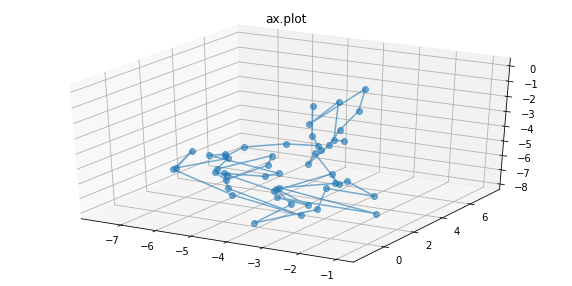

In [139]:
# plotting random walk by normal dist. 아마도 가장 보기 편한 형태
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d') # Axe3D object

sample_size = 50
x = np.cumsum(np.random.normal(0, 1, sample_size))
y = np.cumsum(np.random.normal(0, 1, sample_size))
z = np.cumsum(np.random.normal(0, 1, sample_size))
ax.plot(x, y, z, alpha=0.6, marker='o')
#plt.savefig('../../assets/images/markdown_img/180612_1225_3dplotting_plotting.svg')
plt.title("ax.plot")
plt.show()

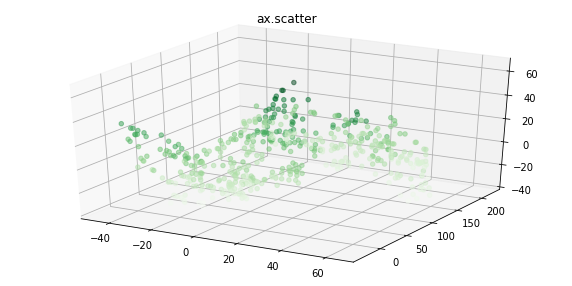

In [140]:
# scattering 두번째로 보기 편한 형태
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d') # Axe3D object

sample_size = 500
x = np.cumsum(np.random.normal(0, 5, sample_size))
y = np.cumsum(np.random.normal(0, 5, sample_size))
z = np.cumsum(np.random.normal(0, 5, sample_size))
ax.scatter(x, y, z, c = z, s= 20, alpha=0.5, cmap=plt.cm.Greens)
#plt.savefig('../../assets/images/markdown_img/180612_1225_3dplotting_scattering.svg')
plt.title("ax.scatter")
plt.show()
